# Projet Traitement et Données Large Échelle

Zoé MARQUIS & Charlotte KRUZIC

!! Attention : Notebook très long (près d'une heure d'exécution)

Cela s'explique par la nature du benchmark :

- Chaque opération (Create, Read, Update, Delete) est répétée 5 fois pour assurer la fiabilité des résultats.
- À chaque Update ou Delete (et même Select pour rester cohérent), il est nécessaire de drop la table et l’index, puis de les recréer.
- Nous avons testé sur différents volumes de données : faible, 8k, et 30k, pour observer les variations de performances.
- Nous avons évalué les performances avec 1, 2, et 5 réplicas.
- Enfin, les tests ont été réalisés avec et sans index.

## Exécution des scripts d'installation 

Nous avons initialement exploré la possibilité d'exécuter nos scripts sur Google Colab afin de faciliter l'exécution sans que vous ayez à configurer quoi que ce soit sur votre machine locale. Cependant, Colab présente certaines limitations, notamment l'incapacité de gérer plusieurs réplicas sets, car il ne permet de travailler qu'avec un seul environnement d'exécution.

Pour pouvoir simuler plusieurs réplicas sets dans notre projet, nous avons besoin de plusieurs nœuds, ce qui n'est pas possible sur Colab. Nous avons également essayé d'utiliser des solutions gratuites comme Datastax (ou une autre plateforme similaire), mais ces services ne permettaient pas de configurer correctement les réplicas sets, ce qui limitait la flexibilité nécessaire à notre projet.

En conséquence, nous avons opté pour une autre solution : créer des fichiers de configuration et utiliser un Jupyter Notebook. Cette approche permet de travailler de manière plus flexible tout en maintenant un contrôle total sur les paramètres des réplicas sets.

Une autre remarque importante : le projet a été testé avec Python 3.11, car Python 3.12 a introduit quelques incompatibilités qui ont causé des bugs. Il est donc recommandé d'utiliser Python 3.11 pour éviter ces problèmes.

TODO CHARLOTTE : mets le set up ubuntu en place 

    sudo apt ...

### Choix de la base de données : MySQL vs SQLite
Initialement, nous avons choisi MySQL pour ses fonctionnalités robustes et sa capacité à gérer de grandes bases de données. Cependant, son intégration à Google Colab a posé plusieurs problèmes :

- Installation et configuration du serveur complexes dans un environnement éphémère.
- Difficulté à maintenir un serveur actif sur Colab, entraînant des arrêts inattendus.
- Configuration complexe pour établir des connexions sécurisées à distance. 

Pour simplifier, nous avons opté pour SQLite, une solution mieux adaptée à nos besoins :

- Sans serveur : Pas de configuration complexe, tout fonctionne directement via des fichiers.
- Compatibilité native : Intégré à Python, fonctionne localement et sur le cloud.

SQLite s'est révélé être une solution efficace, ce qui nous a incités à le conserver lors de notre transition vers Jupyter Notebook.

# Comparaison de Performances entre Systèmes Relationnels et NoSQL : Étude de Cas avec le Catalogue Netflix

Dans ce projet, nous comparons les performances entre un système de base de données relationnel (SQLite) et un système NoSQL (Cassandra), en utilisant le **catalogue Netflix** comme jeu de données.   
Ce dataset, disponible en Open Data, offre une structure réaliste et adaptée pour explorer les différences entre ces deux approches de gestion de données.   
L'objectif principal est d'évaluer les performances des opérations d'insertion, de sélection, de mise à jour et de suppression, tout en explorant les particularités du système NoSQL choisi.

### Jeu de données

Le jeu de données utilisé contient des informations sur les films et séries disponibles sur Netflix, avec les attributs suivants : 
- `show_id` : Identifiant unique pour chaque émission ou film. 
- `type` 
- `title`
- `director` 
- `cast`
- `country`
- `date_added` 
- `release_year` 
- `rating` 
- `duration` 
- `listed_in` 
- `description`

### Schéma de données

```sql
CREATE TABLE IF NOT EXISTS shows (
    show_id INT PRIMARY KEY,
    title TEXT,
    type TEXT,
    director TEXT,
    cast TEXT,
    country TEXT,
    date_added TEXT,
    release_year INT,
    rating TEXT,
    duration TEXT,
    listed_in TEXT,
    description TEXT
);
```


---

## Fonctionnement de Cassandra
Apache Cassandra est un système NoSQL conçu pour gérer de grandes quantités de données de manière distribuée, garantissant haute disponibilité et tolérance aux pannes grâce à son modèle décentralisé et évolutif.

### Modèle de données de Cassandra :

Le modèle de données de Cassandra repose sur quelques concepts clés qui diffèrent des systèmes relationnels traditionnels.

- **Keyspace** :  
Un Keyspace dans Cassandra est l'équivalent d'une base de données dans les systèmes relationnels. Il sert à regrouper des tables (ou Column Families) et définit la stratégie de réplication des données. Par exemple, il spécifie le nombre de répliques à conserver pour chaque donnée afin d'assurer une haute disponibilité et une tolérance aux pannes. La réplication des données dans Cassandra suit des stratégies comme "SimpleStrategy" (réplication sur tous les nœuds) ou "NetworkTopologyStrategy" (réplication sur des nœuds répartis sur plusieurs centres de données). Dans ce projet, nous n'explorerons que la stratégie "SimpleStrategy".
- **Column Family** :  
Une Column Family dans Cassandra est équivalente à une table relationnelle, mais avec une flexibilité plus grande. Chaque Column Family contient plusieurs colonnes, et contrairement aux bases de données relationnelles, les colonnes n'ont pas besoin d'être définies à l'avance. Elles peuvent être ajoutées dynamiquement au fil du temps, ce qui permet d'évoluer facilement sans migrations complexes.
- **Key (Clé primaire)** :  
Chaque ligne dans une Column Family est identifiée par une clé unique. Cette clé est utilisée pour partitionner et localiser les données efficacement. Elle peut être composée d'un seul champ (clé primaire simple) ou de plusieurs champs (clé primaire composée).
- **Colonnes** :  
Les données dans Cassandra sont stockées sous forme de colonnes. Chaque colonne a trois composants essentiels :
    - Nom : Le nom de la colonne (par exemple, title, release_year).
    - Valeur : La donnée proprement dite (par exemple, "Inception", "2010").
    - Timestamp : Le timestamp associé à la colonne, qui permet de gérer les versions des données et de résoudre les conflits de réplication, ce qui est essentiel dans un système distribué. Il permet de savoir quelle version d'une colonne est la plus récente.  
Ces colonnes sont indépendantes les unes des autres. Cela signifie qu'elles peuvent être insérées, mises à jour ou supprimées sans impacter les autres colonnes dans la même ligne.
- **Super Colonnes** :  
Les Super Colonnes sont une structure plus avancée dans Cassandra. Elles permettent de regrouper plusieurs colonnes sous un même nom de "super colonne". Cela permet de créer des structures hiérarchiques ou imbriquées dans les données, où une super colonne peut contenir plusieurs colonnes. Ce mécanisme est utile pour des cas complexes, mais il est souvent moins utilisé au profit de modèles de données plus simples.

Source : 
- http://www-igm.univ-mlv.fr/~dr/XPOSE2010/Cassandra/modele.html

### Les différentes clefs 

- **Clef primaire** :  Identifie de manière unique chaque enregistrement dans la table. Elle est formée de :
    - Clé de partition : Obligatoire.
    - Clés de clustering : Optionnelles.

- **Clef de partition** : Détermine sur quel nœud du cluster les données seront stockées. C'est la première composante de la clé primaire.
Cassandra utilise un algorithme de hachage pour distribuer les partitions uniformément sur les nœuds.
Tous les enregistrements ayant la même clé de partition seront stockés sur le même nœud (dans une partition).

- **Clef de clustering** : Organise les données au sein d'une partition.
Fait partie de la clé primaire, mais intervient après la clé de partition.
Les données sont triées dans l'ordre croissant (par défaut) ou décroissant au sein de chaque partition.

- **Clé secondaire** : Utilisée pour rechercher des données via une colonne qui n'est ni une clé de partition ni une clé de clustering. Cassandra génère un index secondaire pour accélérer les recherches sur cette colonne. Cependant, les performances peuvent être dégradées si l'index est utilisé pour des requêtes impliquant un balayage de nombreuses partitions. Une clé secondaire est définie en créant un **index** sur la colonne souhaitée.

Source: 
- https://www.baeldung.com/cassandra-keys

### Architecture de Cassandra :

L'architecture de Cassandra est décentralisée et repose sur un modèle peer-to-peer, ce qui signifie qu'il n'y a pas de nœud maître ou de coordination centralisée. Tous les nœuds sont égaux et partagent le même rôle. Cela permet une grande scalabilité et une tolérance aux pannes.

- **Partitions et Réplication** : Cassandra répartit les données entre différents nœuds via un mécanisme de partitionnement basé sur un hash de la clé primaire. Chaque nœud du cluster stocke une portion des données, et des répliques de ces données peuvent être présentes sur plusieurs nœuds, selon la stratégie de réplication définie dans le Keyspace. Cela permet à Cassandra d'assurer une haute disponibilité, même en cas de panne d'un ou plusieurs nœuds.
- **Consistence et Quorum** : Cassandra suit un modèle de consistance configurable, permettant de choisir entre des garanties de consistance fortes ou une consistance plus faible en fonction des besoins. Cela se configure via les paramètres Read Consistency Level et Write Consistency Level. Par exemple, un niveau de consistance QUORUM signifie qu'une opération de lecture ou d'écriture devra être validée par la majorité des répliques d'une donnée avant de réussir.

Source:
- https://www.geeksforgeeks.org/quorum-consistency-in-cassandra/

### Requêtes et Modèle de Consistance :

Les requêtes dans Cassandra utilisent le Cassandra Query Language (CQL), qui ressemble à SQL mais avec des différences significatives adaptées aux particularités du modèle NoSQL.

- **Clé primaire et partitions** : Dans Cassandra, la clé primaire détermine comment les données sont partitionnées et distribuées à travers les nœuds du cluster comme expliqué plus haut. Il est essentiel de bien concevoir cette clé pour assurer des performances optimales.
- **Sélection et filtrage** : Cassandra fonctionne très bien pour les requêtes basées sur la clé primaire. Les requêtes qui filtrent sur d'autres colonnes nécessitent l'utilisation d'index secondaires ou d'une modélisation spécifique des données pour garantir de bonnes performances. Filtrer sur une colonne sans index lève l'erreur ALLOW FILTERING, ce qui signifie que la requête pourrait être très coûteuse en termes de performance.

- 

### Avantages et Inconvénients de Cassandra :

#### Avantages :
- **Haute scalabilité horizontale** :
    - Possibilité d'ajouter facilement des nœuds pour s'adapter à une augmentation soudaine de la demande
    - Architecture scalable de façon linéaire permettant de déployer des clusters "multi-node"
- **Résilience et tolérance aux pannes**
    - Réplication des données sur plusieurs nœuds pour garantir une haute disponibilité
    Absence de point unique de défaillance
    - Capacité à continuer à fonctionner même en cas de panne d'un ou plusieurs nœuds
- **Flexibilité du modèle de données**
    - Prise en charge des données structurées, semi-structurées et non structurées
    - Possibilité d'ajouter de nouvelles colonnes sans affecter les données existantes
- **Performances élevées**
    - Impressionnante vitesse d'écriture de données
    - Capacité à traiter de vastes quantités de données dispersées entre de multiples serveurs
#### Inconvénients :
- L'un des principaux inconvénients de Cassandra réside dans la gestion des requêtes sur des colonnes non incluses dans la clé primaire, même lorsqu'un index est présent. Cela peut entraîner des problèmes de performances et nécessiter l'utilisation de la clause ALLOW FILTERING, qui est généralement déconseillée. 
Les index secondaires ne contiennent pas la clé de partition, ce qui oblige Cassandra à rechercher les données sur tous les nœuds du cluster. Cela peut être coûteux en termes de performances, surtout sur de grands clusters.
La clause ALLOW FILTERING est nécessaire lorsque Cassandra ne peut pas garantir une exécution efficace de la requête. Cela se produit souvent pour des requêtes impliquant des comparaisons (comme >, <) ou plusieurs colonnes filtrées sans clé de partition précise. 

Nous avions commencé à faire les comparaison de Select, Update et Delete avec release_year > 2000, mais cela oblige l'utilisation de ALLOW FILTERING, donc ne voyions aucune différence avec et sans index. Nous avons donc tout rejoué avec = 2000 pour pouvoir voir la différence.


Sources : 
- https://www.lebigdata.fr/apache-cassandra-definition
- https://datascientest.com/apache-cassandra
- https://www.scnsoft.com/data/cassandra-performance


### Conclusion :
Cassandra est une base de données extrêmement puissante pour les cas d'utilisation à grande échelle et hautement distribués, avec une grande tolérance aux pannes. Cependant, sa conception impose certaines contraintes sur la manière de structurer les données, et une bonne compréhension de son modèle de partitionnement est essentielle pour garantir de bonnes performances. Si l'application nécessite des requêtes complexes ou des jointures, il est déconseillé d'utiliser Cassandra, car il n'est pas conçu pour ce type de traitement sans outils supplémentaires.


-- 

## Fonctionnement de SQLite
SQLite est une base de données relationnelle légère, autonome et sans serveur, idéale pour les applications nécessitant une gestion locale des données. Voici ses principales caractéristiques :

- **Base embarquée** : Contrairement à MySQL ou PostgreSQL, SQLite est intégré directement dans l'application sans serveur séparé. Les données sont stockées dans un fichier unique.
- **Structure relationnelle** : SQLite suit le modèle relationnel classique avec tables, colonnes et lignes, et prend en charge les requêtes SQL standards (SELECT, INSERT, UPDATE, DELETE).
- **Simplicité** : Pas de serveur à installer ni de configuration complexe, ce qui facilite son utilisation pour des prototypes, des applications mobiles ou locales.
- **Performance** : Bien que performant pour des données locales et de petite taille, SQLite n'est pas conçu pour des applications à grande échelle nécessitant scalabilité ou haute disponibilité.
- **Transactions ACID** : SQLite assure l'intégrité des données avec un modèle transactionnel garantissant l'atomicité et la cohérence, mais sa gestion des transactions simultanées est moins robuste que celle de systèmes plus avancés.

#### Avantages
- **Efficacité en mémoire** : SQLite nécessite peu de mémoire, ce qui la rend rapide et idéale pour des applications de toutes tailles.
- **Autonomie** : Il fonctionne sans serveur externe, ce qui simplifie son intégration et son utilisation.
- **Polyvalence** : SQLite supporte les commandes SQL standard et est compatible avec de nombreux formats de données, ce qui le rend populaire dans diverses applications comme Facebook ou WhatsApp.
- **Portabilité** : Les fichiers SQLite sont faciles à sauvegarder et transférer, sans dépendance à un serveur spécifique.
- **Fiabilité** : Moins sujet aux erreurs de mémoire ou limitations liées à la RAM, avec une faible consommation de ressources.
- **Libre de droits** : SQLite est en domaine public, sans licence, ce qui en fait une solution économique.

#### Limites
- **Absence de gestion multi-utilisateurs** : SQLite ne supporte pas plusieurs utilisateurs ou connexions simultanées, ce qui le rend limité pour les applications multi-clients.
- **Impact de la croissance des données** : La performance peut diminuer avec des volumes importants de données.
- **Limitation des requêtes client** : SQLite ne gère pas bien les requêtes client directes ou les connexions simultanées, ce qui peut causer des retards dans certaines applications.


Sources : 
- https://www.ionos.fr/digitalguide/sites-internet/developpement-web/sqlite/
- https://datascientest.com/sqlite-tout-savoir
- https://www.tutlane.com/tutorial/sqlite/sqlite-acid-transactions
- https://blog.stephane-robert.info/docs/services/bdd/relationnelles/sqlite/

---
## Installer les outils

In [1]:
!pip install plotly matplotlib pandas numpy cassandra_driver kagglehub tabulate

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# importer toutes les librairies nécessaires
from cassandra.cluster import Cluster

import kagglehub

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import random

import sqlite3

from tabulate import tabulate
import time
import tracemalloc

/Users/zoemarquis/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zoemarquis/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importation des données

In [3]:
path = kagglehub.dataset_download("shivamb/netflix-shows")
print("Chemin vers le fichier du dataset : ", path)

Chemin vers le fichier du dataset :  /Users/zoemarquis/.cache/kagglehub/datasets/shivamb/netflix-shows/versions/5


In [4]:
files = os.listdir(path)
print("Nom du fichier : ", files)

Nom du fichier :  ['netflix_titles.csv']


In [5]:
filename = f"{path}/{files[0]}"
df_initial = pd.read_csv(filename)

In [6]:
print(tabulate(df_initial.head(10), headers='keys', tablefmt='psql'))

+----+-----------+---------+----------------------------------+-------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------+--------------------+----------------+----------+------------+---------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | show_id   | type    | title                            | director                      | cast                                                                                                                                                

In [7]:
# afficher le nombre de lignes dans le dataset
print(f"Nombre de lignes : {len(df_initial)}")

Nombre de lignes : 8807


In [8]:
# types des colonnes
print(df_initial.dtypes)

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


In [9]:
# Convertir la colonne show_id en int en enlevant le préfixe 's' 
# (plus simple pour gérer exactement le meme type de données en Cassandra et SQLite)
df_initial['show_id'] = df_initial['show_id'].str.replace('s', '').astype(int).astype(int)

df_initial['show_id'] = df_initial['show_id'].astype(int)
df_initial['release_year'] = df_initial['release_year'].astype(int)

df_initial['type'] = df_initial['title'].astype(str)
df_initial['title'] = df_initial['title'].astype(str)
df_initial['director'] = df_initial['director'].astype(str)
df_initial['cast'] = df_initial['cast'].astype(str)
df_initial['country'] = df_initial['country'].astype(str)
df_initial['date_added'] = df_initial['date_added'].astype(str)
df_initial['rating'] = df_initial['rating'].astype(str)
df_initial['duration'] = df_initial['duration'].astype(str)
df_initial['listed_in'] = df_initial['listed_in'].astype(str)
df_initial['description'] = df_initial['description'].astype(str)

In [10]:
# types des colonnes
print(df_initial.dtypes)

show_id          int64
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


## CRUD : Create, Read, Update, Delete
- Create (*Insert*) : Insérer des données dans la base de données.
- Read (*Select*) : Récupérer des données.
- Update (*Update*) : Modifier des données existantes.
- Delete (*Delete*) : Effacer des données.

In [11]:
schema = """
CREATE TABLE IF NOT EXISTS shows (
    show_id INT PRIMARY KEY,
    title TEXT,
    type TEXT,
    director TEXT,
    cast TEXT,
    country TEXT,
    date_added TEXT,
    release_year INT,
    rating TEXT,
    duration TEXT,
    listed_in TEXT,
    description TEXT
);
"""

In [12]:
# création d'une donnée de test : une ligne pour le film Zoé & Charlotte
data_zoe_charlotte = {
    'show_id': [0],
    'title': ['Zoé & Charlotte'],
    'type': ['Movie'],
    'director': ['Christopher Nolan'],
    'cast': ['Leonardo DiCaprio, Joseph Gordon-Levitt'],
    'country': ['USA'],
    'date_added': ['2021-01-01'],
    'release_year': [2000],
    'rating': ['PG-13'],
    'duration': ['148 min'],
    'listed_in': ['Action, Sci-Fi'],
    'description': ['A thief who steals corporate secrets through the use of dream-sharing technology is given the inverse task of planting an idea into the mind of a CEO.']
}
df_zoe_charlotte = pd.DataFrame(data_zoe_charlotte)

### SQLite

In [13]:
# Créer une base de données SQLite en mémoire
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

def drop_table_sqlite():
    cursor.execute("DROP TABLE IF EXISTS shows;")
    conn.commit()

def create_table_sqlite():
    # Crée ta table ici
    cursor.execute(schema)
    conn.commit()

drop_table_sqlite()
create_table_sqlite()


In [14]:
# SQLite : fonctions pour insérer, lire, mettre à jour et supprimer des données à utiliser pour le benchmark
# on récupère le temps, la mémoire courante et la mémoire maximale utilisée pour chaque opération

# --- CREATE ---
def sqlite_insert(df):
    drop_table_sqlite()
    create_table_sqlite()
    columns = ', '.join(df.columns)
    placeholders = ', '.join(['?'] * len(df.columns))
    insert_query = f"INSERT INTO shows ({columns}) VALUES ({placeholders})"

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
      cursor.execute(insert_query, tuple(row))
    conn.commit()

    create_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Create Time: {create_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return create_time_sqlite, current, peak

# --- READ ---
def sqlite_read(df):
    sqlite_insert(df)

    tracemalloc.start()
    start_time = time.time()
    cursor.execute("SELECT * FROM shows WHERE release_year = 2000")
    result = cursor.fetchall()
    read_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read Time: {read_time_sqlite:.6f} seconds")
    print(f"Queried {len(result)} records")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time_sqlite, current, peak

# --- UPDATE ---
def sqlite_update(df):
    sqlite_insert(df)

    tracemalloc.start() 
    start_time = time.time()
    cursor.execute("UPDATE shows SET rating='PG' WHERE release_year = 2000")
    conn.commit()
    update_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()

    print(f"Update Time: {update_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time_sqlite, current, peak

# --- DELETE ---
def sqlite_delete(df):
    sqlite_insert(df)

    tracemalloc.start()
    start_time = time.time()
    cursor.execute("DELETE FROM shows WHERE release_year = 2000")
    conn.commit()
    delete_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete Time: {delete_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time_sqlite, current, peak

In [15]:
# Fonction pour effectuer une opération plusieurs fois et calculer la moyenne et l'écart-type
def benchmark_operation(func, *args):
    times = []
    current_memory = []
    peak_memory = []
    for _ in range(5):  # Effectuer 5 itérations
        temps, current, peak = func(*args)  # Exécuter la fonction avec les arguments
        times.append(temps)
        current_memory.append(current)
        peak_memory.append(peak)
    
    # Calculer la moyenne et l'écart-type
    mean_time = np.mean(times)
    std_time = np.std(times)
    mean_current_memory = np.mean(current_memory)
    std_current_memory = np.std(current_memory)
    mean_peak_memory = np.mean(peak_memory)
    std_peak_memory = np.std(peak_memory)
    return mean_time, std_time, mean_current_memory, std_current_memory, mean_peak_memory, std_peak_memory

# --- CREATE ---
create_sqlite_mean_time, create_sqlite_std_time, \
    create_sqlite_mean_current_memory, create_sqlite_std_current_memory, \
        create_sqlite_mean_peak_memory, create_sqlite_std_peak_memory = benchmark_operation(sqlite_insert, df_zoe_charlotte)

# --- READ ---
read_sqlite_mean_time, read_sqlite_std_time, \
    read_sqlite_mean_current_memory, read_sqlite_std_current_memory, \
        read_sqlite_mean_peak_memory, read_sqlite_std_peak_memory = benchmark_operation(sqlite_read, df_zoe_charlotte)

# --- UPDATE ---
update_sqlite_mean_time, update_sqlite_std_time, \
    update_sqlite_mean_current_memory, update_sqlite_std_current_memory, \
        update_sqlite_mean_peak_memory, update_sqlite_std_peak_memory = benchmark_operation(sqlite_update, df_zoe_charlotte)

# --- DELETE ---
delete_sqlite_mean_time, delete_sqlite_std_time, \
    delete_sqlite_mean_current_memory, delete_sqlite_std_current_memory, \
        delete_sqlite_mean_peak_memory, delete_sqlite_std_peak_memory = benchmark_operation(sqlite_delete, df_zoe_charlotte)

Create Time: 0.000405 seconds
Current memory usage is 0.001766204833984375Mo; Peak was 0.003170013427734375Mo
Create Time: 0.000318 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000126 seconds
Current memory usage is 0.001308441162109375Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000106 seconds
Current memory usage is 0.001308441162109375Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000100 seconds
Current memory usage is 0.001308441162109375Mo; Peak was 0.003093719482421875Mo
Create Time: 0.000100 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Read Time: 0.000021 seconds
Queried 1 records
Current memory usage is 0.0023555755615234375Mo; Peak was 0.0024013519287109375Mo
Create Time: 0.000088 seconds
Current memory usage is 0.001285552978515625Mo; Peak was 0.003093719482421875Mo
Read Time: 0.000014 seconds
Queried 1 records
Current memory usage is 0.0014476776123046875Mo; Peak wa

##### Test d'insertion avec une ligne de DataFrame
Nous avons d'abord testé l'insertion d'une seule ligne de données extraite d'un DataFrame dans notre base de données. 

Cette étape permet de vérifier que l'insertion fonctionne correctement sur un cas simple, avant de passer à l'insertion de l'ensemble du DataFrame.

À ce stade, l'insertion a été réalisée avec succès sur une ligne de données, ce qui nous permet d'assurer que la logique de base est correcte. 

Nous allons maintenant procéder à l'insertion du DataFrame complet pour tester la gestion de plusieurs lignes et évaluer les performances d'insertion à plus grande échelle.

In [16]:
# --- CREATE ---
create_sqlite_massive_mean_time, create_sqlite_massive_std_time, \
    create_sqlite_massive_mean_current_memory, create_sqlite_massive_std_current_memory,\
    create_sqlite_massive_mean_peak_memory, create_sqlite_massive_std_peak_memory  = benchmark_operation(sqlite_insert, df_initial)

# --- READ ---
read_sqlite_massive_mean_time, read_sqlite_massive_std_time, \
    read_sqlite_massive_mean_current_memory, read_sqlite_massive_std_current_memory,\
    read_sqlite_massive_mean_peak_memory, read_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_read, df_initial)

# --- UPDATE ---
update_sqlite_massive_mean_time, update_sqlite_massive_std_time, \
    update_sqlite_massive_mean_current_memory, update_sqlite_massive_std_current_memory,\
    update_sqlite_massive_mean_peak_memory, update_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_update, df_initial)

# --- DELETE ---
delete_sqlite_massive_mean_time, delete_sqlite_massive_std_time, \
    delete_sqlite_massive_mean_current_memory, delete_sqlite_massive_std_current_memory,\
    delete_sqlite_massive_mean_peak_memory, delete_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_delete, df_initial)

Create Time: 0.409458 seconds
Current memory usage is 1.6779260635375977Mo; Peak was 1.680455207824707Mo
Create Time: 0.375300 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Create Time: 0.373141 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Create Time: 0.373741 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Create Time: 0.379975 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Create Time: 0.374364 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Read Time: 0.000725 seconds
Queried 37 records
Current memory usage is 0.04055595397949219Mo; Peak was 0.04055595397949219Mo
Create Time: 0.384882 seconds
Current memory usage is 1.2714948654174805Mo; Peak was 1.4052963256835938Mo
Read Time: 0.000819 seconds
Queried 37 records
Current memory usage is 0.03601646423339844Mo; Peak was 0.03601646423339844Mo
Create Ti

### Cassandra

In [17]:
# vérifier l'état actuel du noeud Cassandra
!nodetool status

Datacenter: datacenter1
Status=Up/Down
|/ State=Normal/Leaving/Joining/Moving
--  Address    Load      Tokens  Owns (effective)  Host ID                               Rack 
UN  127.0.0.1  1,83 MiB  16      100,0%            11c2e131-3642-40ab-a44b-5d5e95f42edb  rack1



In [18]:
# Connexion à Cassandra
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()


def drop_table_cassandra():
    session.execute("""
        DROP TABLE IF EXISTS netflix.shows;
        """)
    session.execute("""
        DROP KEYSPACE IF EXISTS netflix;
        """)

def create_table_cassandra(replication_factor):
    session.execute(f"""
        CREATE KEYSPACE netflix
        WITH REPLICATION = {{
            'class': 'SimpleStrategy', 
            'replication_factor': {replication_factor}
        }};
        """)
    session.set_keyspace('netflix')
    session.execute(schema)
    print(f"replication factor = {replication_factor}")

     
drop_table_cassandra()
create_table_cassandra(1)

replication factor = 1


##### Test sans index
Pour l'instant, nous effectuons les tests sans index. Cette approche nous permettra d'évaluer les performances de base. Nous ajouterons ensuite des index pour comparer les résultats et analyser l'impact sur les performances des requêtes.

In [19]:
# Cassandra : fonctions pour insérer, lire, mettre à jour et supprimer des données à utiliser pour le benchmark
# on récupère le temps, la mémoire courante et la mémoire maximale utilisée pour chaque opération

# nb_repl : pour la suite, on va tester avec 1, 2 et 5 replica

# Attention ici aux commentaires : on a besoin d'utiliser allow filtering, et de faire un select avant de faire un update ou un delete : 
# on explique pourquoi plus loin 

# --- CREATE ---
def cassandra_insert(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    drop_table_cassandra()
    create_table_cassandra(nb_repl)

    insert_query = session.prepare("INSERT INTO shows (show_id, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)")

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
        session.execute(insert_query, (row['show_id'], row['title'], row['director'], row['cast'], row['country'], row['date_added'], row['release_year'], row['rating'], row['duration'], row['listed_in'], row['description']))
    create_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()

    print(f"Create Time: {create_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")

    return create_time, current, peak

# --- READ ---
def cassandra_read(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    cassandra_insert(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    # On utilise ici ALLOW FILTERING car release_year ne fait pas partie de la clef primaire et n'est pas indexé
    result = session.execute("SELECT * FROM shows WHERE release_year = 2000 ALLOW FILTERING")
    read_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read Time: {read_time:.6f} seconds")
    num_records = sum(1 for _ in result)  # Count rows using a generator expression
    print(f"Queried {num_records} records")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time, current, peak

# --- UPDATE ---
def cassandra_update(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    cassandra_insert(df, nb_repl)

    tracemalloc.start()
    # On doit faire select et update car realease_year ne fait pas partie de la clef primaire
    start_time = time.time()

    select_query = "SELECT show_id FROM shows WHERE release_year = 2000 ALLOW FILTERING;" 
    result = session.execute(select_query)
    show_ids_to_update = [row.show_id for row in result]

    for show_id in show_ids_to_update:
        update_query = f"UPDATE shows SET rating = 'PG' WHERE show_id = {show_id};"
        session.execute(update_query)

    update_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Update Time: {update_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time, current, peak

# --- DELETE ---
def cassandra_delete(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    cassandra_insert(df, nb_repl)
    
    # Comme pour update
    tracemalloc.start()
    start_time = time.time()

    select_query = "SELECT show_id FROM shows WHERE release_year = 2000 ALLOW FILTERING;"
    result = session.execute(select_query)
    show_ids_to_delete = [row.show_id for row in result]

    for show_id in show_ids_to_delete:
        delete_query = f"DELETE FROM shows WHERE show_id = {show_id};"
        session.execute(delete_query)

    delete_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete Time: {delete_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time, current, peak

In [20]:
# --- CREATE ---
create_cas_mean_time, create_cas_std_time, \
    create_cas_mean_current_memory, create_cas_std_current_memory, \
        create_cas_mean_peak_memory, create_cas_std_peak_memory  = benchmark_operation(cassandra_insert, df_zoe_charlotte, 1)

# --- READ ---
read_cas_mean_time, read_cas_std_time, read_cas_mean_current_memory, \
    read_cas_std_current_memory, read_cas_mean_peak_memory, \
        read_cas_std_peak_memory  = benchmark_operation(cassandra_read, df_zoe_charlotte, 1)

# --- UPDATE ---
update_cas_mean_time, update_cas_std_time, \
    update_cas_mean_current_memory, update_cas_std_current_memory, \
        update_cas_mean_peak_memory, update_cas_std_peak_memory  = benchmark_operation(cassandra_update, df_zoe_charlotte, 1)

# --- DELETE ---
delete_cas_mean_time, delete_cas_std_time,  \
    delete_cas_mean_current_memory, delete_cas_std_current_memory,  \
        delete_cas_mean_peak_memory, delete_cas_std_peak_memory  = benchmark_operation(cassandra_delete, df_zoe_charlotte, 1)

replication factor = 1
Create Time: 0.003549 seconds
Current memory usage is 0.013118743896484375Mo; Peak was 0.01779651641845703Mo
replication factor = 1
Create Time: 0.002638 seconds
Current memory usage is 0.00666046142578125Mo; Peak was 0.011338233947753906Mo
replication factor = 1
Create Time: 0.002354 seconds
Current memory usage is 0.006622314453125Mo; Peak was 0.011300086975097656Mo
replication factor = 1
Create Time: 0.002154 seconds
Current memory usage is 0.006622314453125Mo; Peak was 0.011300086975097656Mo
replication factor = 1
Create Time: 0.002137 seconds
Current memory usage is 0.006622314453125Mo; Peak was 0.011300086975097656Mo
replication factor = 1
Create Time: 0.002381 seconds
Current memory usage is 0.006622314453125Mo; Peak was 0.011300086975097656Mo
Read Time: 0.002858 seconds
Queried 1 records
Current memory usage is 0.012326240539550781Mo; Peak was 0.04303455352783203Mo
replication factor = 1
Create Time: 0.001938 seconds
Current memory usage is 0.006622314453

In [21]:
# --- CREATE ---
create_cas_massive_mean_time, create_cas_massive_std_time, \
    create_cas_massive_mean_current_memory, create_cas_massive_std_current_memory, \
        create_cas_massive_mean_peak_memory, create_cas_massive_std_peak_memory = benchmark_operation(cassandra_insert, df_initial, 1)

# --- READ ---
read_cas_massive_mean_time, read_cas_massive_std_time, \
    read_cas_massive_mean_current_memory, read_cas_massive_std_current_memory, \
        read_cas_massive_mean_peak_memory, read_cas_massive_std_peak_memory = benchmark_operation(cassandra_read, df_initial, 1)

# --- UPDATE ---
update_cas_massive_mean_time, update_cas_massive_std_time, \
    update_cas_massive_mean_current_memory, update_cas_massive_std_current_memory, \
        update_cas_massive_mean_peak_memory, update_cas_massive_std_peak_memory = benchmark_operation(cassandra_update, df_initial, 1)

# --- DELETE ---
delete_cas_massive_mean_time, delete_cas_massive_std_time, \
    delete_cas_massive_mean_current_memory, delete_cas_massive_std_current_memory, \
        delete_cas_massive_mean_peak_memory, delete_cas_massive_std_peak_memory = benchmark_operation(cassandra_delete, df_initial, 1)

replication factor = 1
Create Time: 4.043886 seconds
Current memory usage is 1.5372724533081055Mo; Peak was 1.6492385864257812Mo
replication factor = 1
Create Time: 4.022146 seconds
Current memory usage is 1.6019439697265625Mo; Peak was 1.6221351623535156Mo
replication factor = 1
Create Time: 4.008925 seconds
Current memory usage is 1.5628910064697266Mo; Peak was 1.6233453750610352Mo
replication factor = 1
Create Time: 3.993075 seconds
Current memory usage is 1.5341243743896484Mo; Peak was 1.6220779418945312Mo
replication factor = 1
Create Time: 3.956527 seconds
Current memory usage is 1.4841880798339844Mo; Peak was 1.615011215209961Mo
replication factor = 1
Create Time: 4.054156 seconds
Current memory usage is 1.5809688568115234Mo; Peak was 1.6178703308105469Mo
Read Time: 0.008746 seconds
Queried 37 records
Current memory usage is 0.05277061462402344Mo; Peak was 0.11112308502197266Mo
replication factor = 1
Create Time: 4.026862 seconds
Current memory usage is 1.574615478515625Mo; Peak

### Visualisation
Nous avons d'abord testé avec un seul replicaSet et sans index, en insérant une seule ligne de données pour simplifier les tests.

Ensuite, pour obtenir des statistiques plus réalistes, nous avons effectué des opérations CRUD sur un volume de données plus important, en utilisant les données de Kaggle précédemment chargées. 

Chaque action (insertion, lecture, mise à jour, suppression) a été réalisée cinq fois, et nous avons calculé la moyenne et l'écart-type pour chaque opération afin d'effectuer un benchmarking précis.

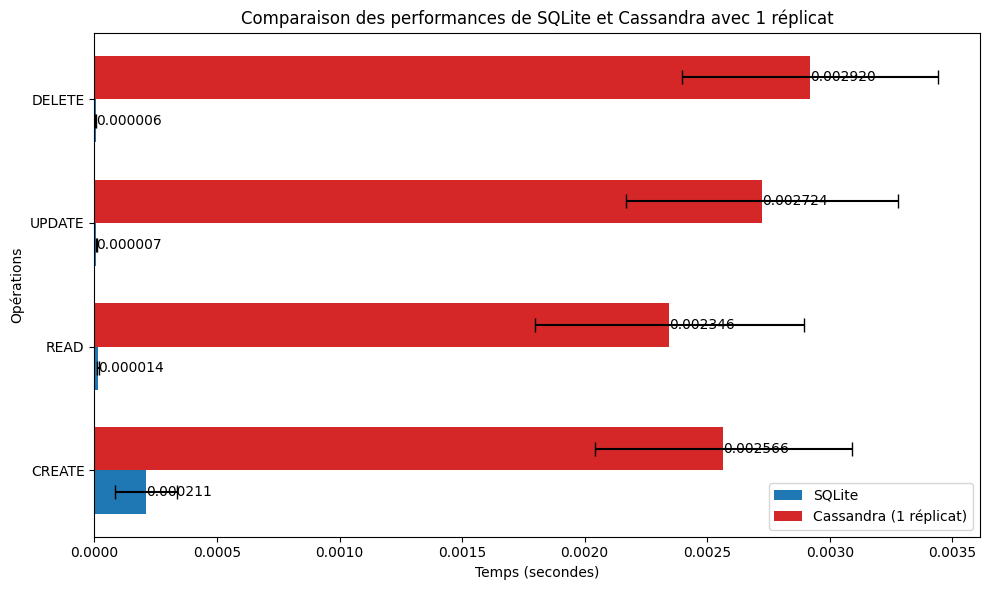

In [22]:
# Valeurs de temps pour SQLite
sqlite_times = {
    'CREATE': (create_sqlite_mean_time, create_sqlite_std_time),
    'READ': (read_sqlite_mean_time, read_sqlite_std_time),
    'UPDATE': (update_sqlite_mean_time, update_sqlite_std_time),
    'DELETE': (delete_sqlite_mean_time, delete_sqlite_std_time)
}

# Valeurs de temps pour Cassandra avec 1 réplicat
cassandra_times = {
    'CREATE': (create_cas_mean_time, create_cas_std_time),
    'READ': (read_cas_mean_time, read_cas_std_time),
    'UPDATE': (update_cas_mean_time, update_cas_std_time),
    'DELETE': (delete_cas_mean_time, delete_cas_std_time)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

y = np.arange(len(operations))
height = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.barh(y - height / 2, sqlite_means, height, xerr=sqlite_stds, label='SQLite', capsize=5, color='tab:blue')
bars2 = ax.barh(y + height / 2, cassandra_means, height, xerr=cassandra_stds, label='Cassandra (1 réplicat)', capsize=5, color='tab:red')

ax.set_xlabel('Temps (secondes)')
ax.set_ylabel('Opérations')
ax.set_title('Comparaison des performances de SQLite et Cassandra avec 1 réplicat') 
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

add_values(bars1)
add_values(bars2)

plt.tight_layout()
plt.show()


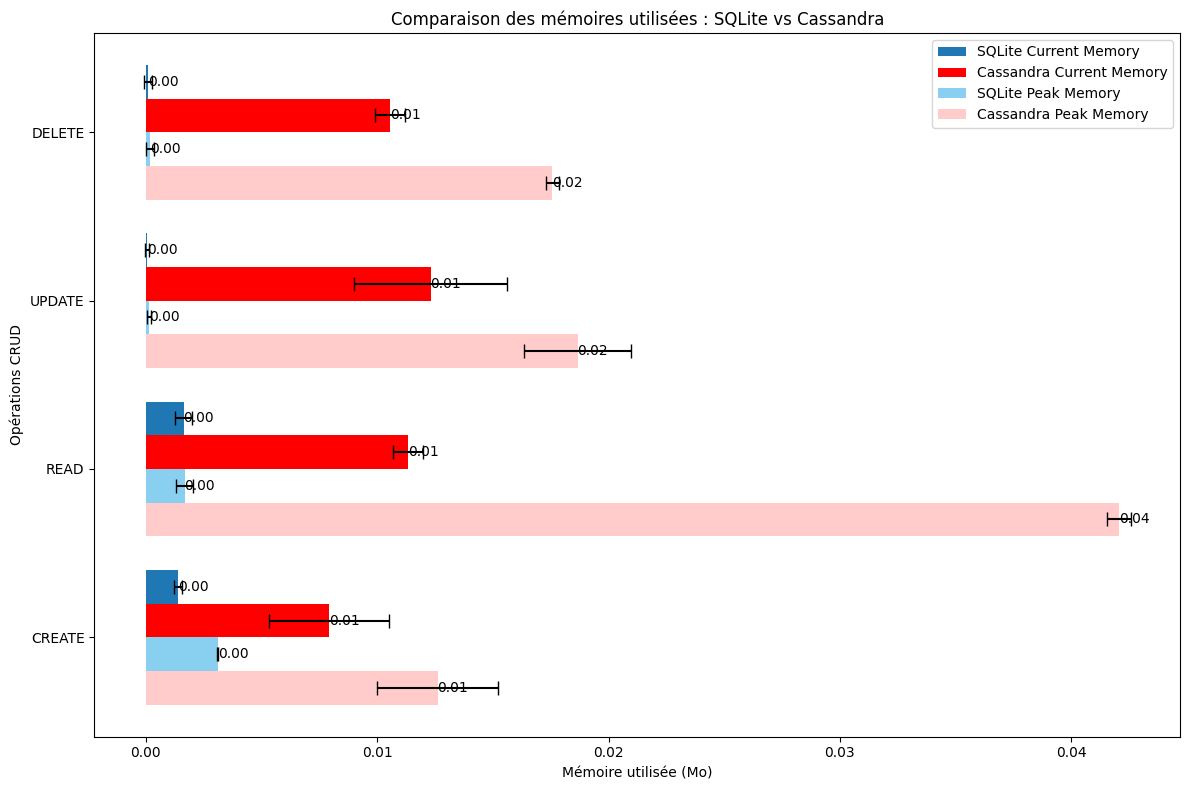

In [23]:
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_mean_current_memory, create_sqlite_std_current_memory),
               'peak': (create_sqlite_mean_peak_memory, create_sqlite_std_peak_memory)},
    'READ': {'current': (read_sqlite_mean_current_memory, read_sqlite_std_current_memory),
             'peak': (read_sqlite_mean_peak_memory, read_sqlite_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_mean_current_memory, update_sqlite_std_current_memory),
               'peak': (update_sqlite_mean_peak_memory, update_sqlite_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_mean_current_memory, delete_sqlite_std_current_memory),
               'peak': (delete_sqlite_mean_peak_memory, delete_sqlite_std_peak_memory)}
}

cassandra_memory = {
    'CREATE': {'current': (create_cas_mean_current_memory, create_cas_std_current_memory),
               'peak': (create_cas_mean_peak_memory, create_cas_std_peak_memory)},
    'READ': {'current': (read_cas_mean_current_memory, read_cas_std_current_memory),
             'peak': (read_cas_mean_peak_memory, read_cas_std_peak_memory)},
    'UPDATE': {'current': (update_cas_mean_current_memory, update_cas_std_current_memory),
               'peak': (update_cas_mean_peak_memory, update_cas_std_peak_memory)},
    'DELETE': {'current': (delete_cas_mean_current_memory, delete_cas_std_current_memory),
               'peak': (delete_cas_mean_peak_memory, delete_cas_std_peak_memory)}
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = [cassandra_memory[op]['current'][0] for op in operations]
cassandra_current_stds = [cassandra_memory[op]['current'][1] for op in operations]
cassandra_peak_means = [cassandra_memory[op]['peak'][0] for op in operations]
cassandra_peak_stds = [cassandra_memory[op]['peak'][1] for op in operations]

y = np.arange(len(operations))  
height = 0.2  

fig, ax = plt.subplots(figsize=(12, 8))

bars_sqlite_current = ax.barh(y + 1.5 * height, sqlite_current_means, height, 
                              xerr=sqlite_current_stds, label='SQLite Current Memory', color='tab:blue', capsize=5)
bars_cassandra_current = ax.barh(y + 0.5 * height, cassandra_current_means, height, 
                                  xerr=cassandra_current_stds, label='Cassandra Current Memory', color='red', capsize=5)
bars_sqlite_peak = ax.barh(y - 0.5 * height, sqlite_peak_means, height, 
                           xerr=sqlite_peak_stds, label='SQLite Peak Memory', color='#89CFF0', capsize=5) # bleu clair
bars_cassandra_peak = ax.barh(y - 1.5 * height, cassandra_peak_means, height, 
                               xerr=cassandra_peak_stds, label='Cassandra Peak Memory', color='#FFCCCB', capsize=5) # rouge clair

ax.set_xlabel('Mémoire utilisée (Mo)')
ax.set_ylabel('Opérations CRUD')
ax.set_title('Comparaison des mémoires utilisées : SQLite vs Cassandra')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

add_values(bars_sqlite_current)
add_values(bars_cassandra_current)
add_values(bars_sqlite_peak)
add_values(bars_cassandra_peak)

plt.tight_layout()
plt.show()


En testant SQLite et Cassandra avec une seule ligne de données et une réplication pour Cassandra, on remarque des différences claires :
 
- SQLite :  
Ici, l'opération la plus lente est la création de la ligne de données. En revanche, les lectures, mises à jour et suppressions sont rapides, ce qui montre que SQLite est bien optimisé pour des petits volumes de données.  
- Cassandra :  
La lecture est l'opération la plus rapide, ce qui correspond bien à la manière dont Cassandra est conçu pour gérer les requêtes en lecture.  
Les mises à jour et suppressions prennent à peu près le même temps, et sont un peu plus rapides que la création.  
La création, par contre, est la plus lente, probablement à cause de la gestion de la réplication et des contraintes liées à son architecture distribuée.    

On fait le même constat concernant la mémoire (current et peak), où Cassandra est beaucoup plus gourmand que SQLite, notamment avec un pic énorme en lecture pour Cassandra.

Globalement, avec une seule ligne de données, Cassandra est beaucoup plus lent que SQLite. Cela s’explique par son architecture distribuée, qui ajoute un overhead même dans des contextes simples, et par ses mécanismes de réplication et de gestion des partitions, conçus pour des scénarios à grande échelle. En revanche, SQLite, étant une solution locale et légère, est optimisé pour des opérations rapides sur de petites bases de données.


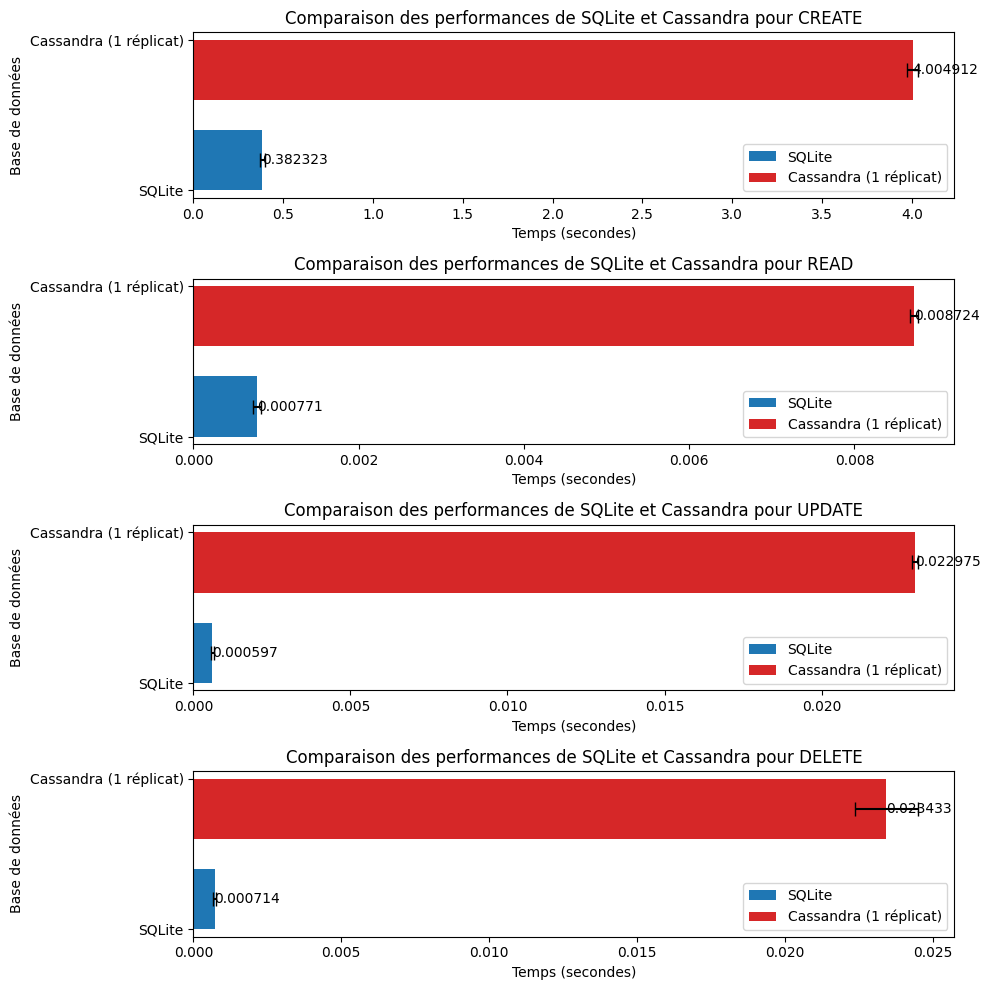

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Données des temps de SQLite et Cassandra pour chaque opération
sqlite_times = {
    'CREATE': (create_sqlite_massive_mean_time, create_sqlite_massive_std_time),
    'READ': (read_sqlite_massive_mean_time, read_sqlite_massive_std_time),
    'UPDATE': (update_sqlite_massive_mean_time, update_sqlite_massive_std_time),
    'DELETE': (delete_sqlite_massive_mean_time, delete_sqlite_massive_std_time)
}

cassandra_times = {
    'CREATE': (create_cas_massive_mean_time, create_cas_massive_std_time),
    'READ': (read_cas_massive_mean_time, read_cas_massive_std_time),
    'UPDATE': (update_cas_massive_mean_time, update_cas_massive_std_time),
    'DELETE': (delete_cas_massive_mean_time, delete_cas_massive_std_time)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Extraire les moyennes et les écarts-types pour chaque opération
sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

# Créer un graphique pour chaque opération
fig, axes = plt.subplots(4, 1, figsize=(10, 10))  # 4 graphiques sous le même format
height = 0.4

for i, op in enumerate(operations):
    ax = axes[i]
    y = np.arange(2)  # Deux barres par graphique pour SQLite et Cassandra

    # Barres pour SQLite et Cassandra
    bars1 = ax.barh(y[0] + height / 2, sqlite_times[op][0], height, xerr=sqlite_times[op][1], label='SQLite', capsize=5, color='tab:blue')
    bars2 = ax.barh(y[1] - height / 2, cassandra_times[op][0], height, xerr=cassandra_times[op][1], label='Cassandra (1 réplicat)', capsize=5, color='tab:red')

    # Titre et labels
    ax.set_xlabel('Temps (secondes)')
    ax.set_ylabel('Base de données')
    ax.set_title(f'Comparaison des performances de SQLite et Cassandra pour {op}')
    ax.set_yticks(y)
    ax.set_yticklabels(['SQLite', 'Cassandra (1 réplicat)'])
    ax.legend()

    # Ajout des valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)

# Ajustement des graphiques pour qu'ils soient bien espacés
plt.tight_layout()
plt.show()


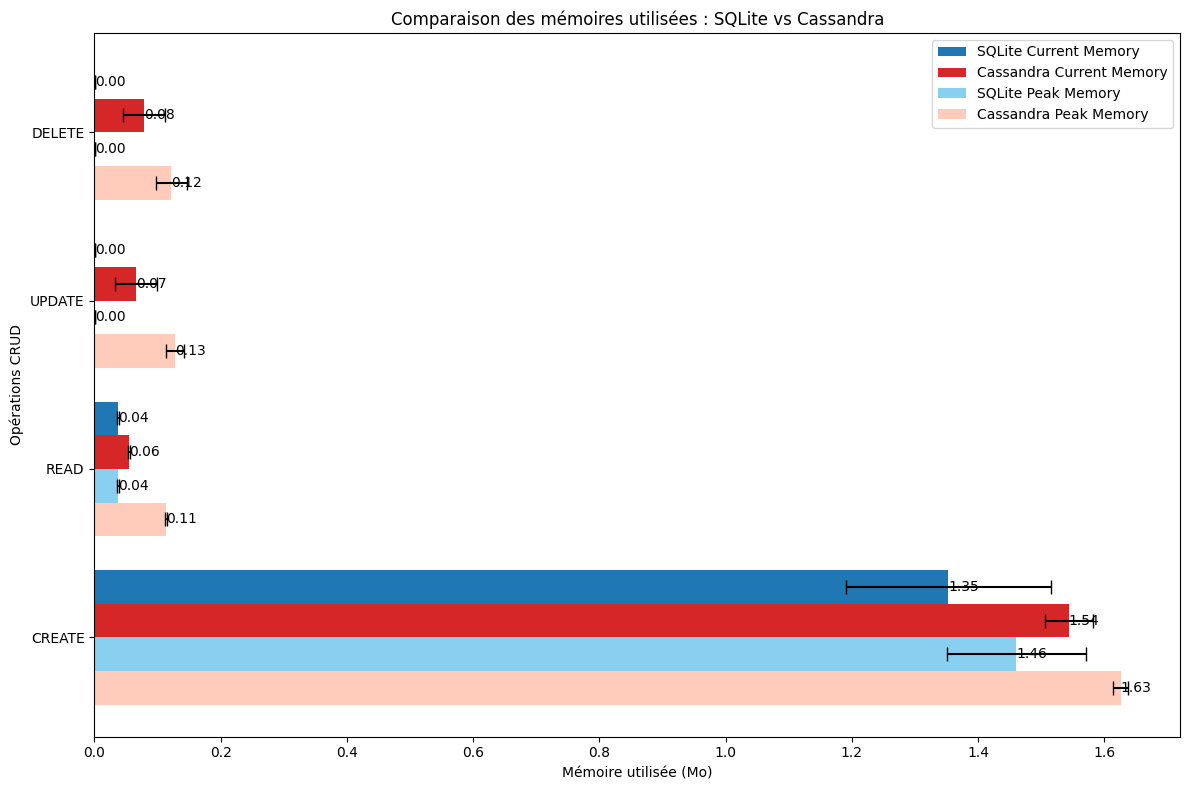

In [25]:
# Valeurs de mémoire pour SQLite (current et peak)
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_massive_mean_current_memory, create_sqlite_massive_std_current_memory),
               'peak': (create_sqlite_massive_mean_peak_memory, create_sqlite_massive_std_peak_memory)},
    'READ': {'current': (read_sqlite_massive_mean_current_memory, read_sqlite_massive_std_current_memory),
             'peak': (read_sqlite_massive_mean_peak_memory, read_sqlite_massive_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_massive_mean_current_memory, update_sqlite_massive_std_current_memory),
               'peak': (update_sqlite_massive_mean_peak_memory, update_sqlite_massive_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_massive_mean_current_memory, delete_sqlite_massive_std_current_memory),
               'peak': (delete_sqlite_massive_mean_peak_memory, delete_sqlite_massive_std_peak_memory)}
}

# Valeurs de mémoire pour Cassandra (current et peak)
cassandra_memory = {
    'CREATE': {'current': (create_cas_massive_mean_current_memory, create_cas_massive_std_current_memory),
               'peak': (create_cas_massive_mean_peak_memory, create_cas_massive_std_peak_memory)},
    'READ': {'current': (read_cas_massive_mean_current_memory, read_cas_massive_std_current_memory),
             'peak': (read_cas_massive_mean_peak_memory, read_cas_massive_std_peak_memory)},
    'UPDATE': {'current': (update_cas_massive_mean_current_memory, update_cas_massive_std_current_memory),
               'peak': (update_cas_massive_mean_peak_memory, update_cas_massive_std_peak_memory)},
    'DELETE': {'current': (delete_cas_massive_mean_current_memory, delete_cas_massive_std_current_memory),
               'peak': (delete_cas_massive_mean_peak_memory, delete_cas_massive_std_peak_memory)}
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = [cassandra_memory[op]['current'][0] for op in operations]
cassandra_current_stds = [cassandra_memory[op]['current'][1] for op in operations]
cassandra_peak_means = [cassandra_memory[op]['peak'][0] for op in operations]
cassandra_peak_stds = [cassandra_memory[op]['peak'][1] for op in operations]

y = np.arange(len(operations)) 
height = 0.2  

fig, ax = plt.subplots(figsize=(12, 8))

bars_sqlite_current = ax.barh(y + 1.5 * height, sqlite_current_means, height, 
                              xerr=sqlite_current_stds, label='SQLite Current Memory', color='tab:blue', capsize=5)
bars_cassandra_current = ax.barh(y + 0.5 * height, cassandra_current_means, height, 
                                  xerr=cassandra_current_stds, label='Cassandra Current Memory', color='tab:red', capsize=5)
bars_sqlite_peak = ax.barh(y - 0.5 * height, sqlite_peak_means, height, 
                           xerr=sqlite_peak_stds, label='SQLite Peak Memory', color='#89CFF0', capsize=5)
bars_cassandra_peak = ax.barh(y - 1.5 * height, cassandra_peak_means, height, 
                               xerr=cassandra_peak_stds, label='Cassandra Peak Memory', color='#FFCCBB', capsize=5)

ax.set_xlabel('Mémoire utilisée (Mo)')
ax.set_ylabel('Opérations CRUD')
ax.set_title('Comparaison des mémoires utilisées : SQLite vs Cassandra')
ax.set_yticks(y)
ax.set_yticklabels(operations)
ax.legend()

def add_values(bars):
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

add_values(bars_sqlite_current)
add_values(bars_cassandra_current)
add_values(bars_sqlite_peak)
add_values(bars_cassandra_peak)

plt.tight_layout()
plt.show()


Sur un volume de données beaucoup plus important, avec toujours un seul réplicat, la requête de création (CREATE) reste la plus longue pour SQLite comme pour Cassandra.

En Cassandra, les requêtes de lecture (READ) sont particulièrement rapides par rapport aux autres types de requêtes. Cela s'explique par la structure optimisée de Cassandra pour des lectures rapides, grâce à son indexation basée sur les partitions et l'utilisation de SSTables.

En revanche, les requêtes de suppression (DELETE) et de mise à jour (UPDATE) sont globalement plus longues et prennent un temps similaire en Cassandra, en raison des mécanismes internes de gestion des tombstones et de la propagation des modifications.

Enfin, même sur un grand volume de données, Cassandra reste globalement bien plus lent que SQLite, reflétant la différence entre une architecture distribuée conçue pour des données massives et une solution locale optimisée pour des bases de données plus légères.

Idées de pourquoi Cassandra reste plus lent : 
- Cassandra distribué : Optimisé pour des bases massives, mais sa gestion des partitions et des nœuds ajoute un coût, même sur une petite base.
- Replication : Même avec un seul réplicat, Cassandra gère la synchronisation, ce qui ralentit les écritures.
- Caching : SQLite utilise la mémoire locale efficacement, tandis que Cassandra coordonne entre nœuds, ce qui prend plus de temps.

TODO ZOE vérifier ce qui est dit ici 

## Comparaison des temps de Cassandra avec plusieurs replicaSet

##### Qu'est ce que *SimpleStrategy* ?
Description : Réplique les données de manière linéaire sur les n nœuds du cluster, où n est le replication_factor.
- Avantages :
    - Simple à configurer.
    - Adapté aux environnements de test ou aux clusters d'une seule région.
- Inconvénients :
    - Pas optimisé pour les déploiements multi-régions.
    - Répartition des réplicas pas toujours équilibrée en cas de cluster complexe.

In [26]:
# 2 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_2, create_cassandra_massive_std_time_2, \
    create_cassandra_massive_mean_current_memory_2, create_cassandra_massive_std_current_memory_2, \
        create_cassandra_massive_mean_peak_memory_2, create_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_insert, df_initial, 2)

# --- READ ---
read_cassandra_massive_mean_time_2, read_cassandra_massive_std_time_2, \
    read_cassandra_massive_mean_current_memory_2, read_cassandra_massive_std_current_memory_2, \
        read_cassandra_massive_mean_peak_memory_2, read_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_read, df_initial, 2)

# --- UPDATE ---
update_cassandra_massive_mean_time_2, update_cassandra_massive_std_time_2, \
    update_cassandra_massive_mean_current_memory_2, update_cassandra_massive_std_current_memory_2, \
        update_cassandra_massive_mean_peak_memory_2, update_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_update, df_initial, 2)

# --- DELETE ---
delete_cassandra_massive_mean_time_2, delete_cassandra_massive_std_time_2, \
    delete_cassandra_massive_mean_current_memory_2, delete_cassandra_massive_std_current_memory_2, \
        delete_cassandra_massive_mean_peak_memory_2, delete_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_delete, df_initial, 2)

replication factor = 2
Create Time: 4.266751 seconds
Current memory usage is 1.4842023849487305Mo; Peak was 1.6372795104980469Mo
replication factor = 2
Create Time: 4.303336 seconds
Current memory usage is 1.5557632446289062Mo; Peak was 1.6202335357666016Mo
replication factor = 2
Create Time: 4.264538 seconds
Current memory usage is 1.512040138244629Mo; Peak was 1.6214561462402344Mo
replication factor = 2
Create Time: 4.236797 seconds
Current memory usage is 1.471658706665039Mo; Peak was 1.6253662109375Mo
replication factor = 2
Create Time: 4.309542 seconds
Current memory usage is 1.567209243774414Mo; Peak was 1.6227426528930664Mo
replication factor = 2
Create Time: 4.282692 seconds
Current memory usage is 1.5321950912475586Mo; Peak was 1.6375761032104492Mo
Read Time: 0.008739 seconds
Queried 37 records
Current memory usage is 0.05710029602050781Mo; Peak was 0.11362171173095703Mo
replication factor = 2
Create Time: 4.264635 seconds
Current memory usage is 1.5739850997924805Mo; Peak was

In [27]:
# 5 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_5, create_cassandra_massive_std_time_5, \
    create_cassandra_massive_mean_current_memory_5, create_cassandra_massive_std_current_memory_5, \
        create_cassandra_massive_mean_peak_memory_5, create_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_insert, df_initial, 5)

# --- READ ---
read_cassandra_massive_mean_time_5, read_cassandra_massive_std_time_5, \
    read_cassandra_massive_mean_current_memory_5, read_cassandra_massive_std_current_memory_5, \
        read_cassandra_massive_mean_peak_memory_5, read_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_read, df_initial, 5)

# --- UPDATE ---
update_cassandra_massive_mean_time_5, update_cassandra_massive_std_time_5, \
    update_cassandra_massive_mean_current_memory_5, update_cassandra_massive_std_current_memory_5, \
        update_cassandra_massive_mean_peak_memory_5, update_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_update, df_initial, 5)

# --- DELETE ---
delete_cassandra_massive_mean_time_5, delete_cassandra_massive_std_time_5, \
    delete_cassandra_massive_mean_current_memory_5, delete_cassandra_massive_std_current_memory_5, \
        delete_cassandra_massive_mean_peak_memory_5, delete_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_delete, df_initial, 5)

replication factor = 5
Create Time: 4.243979 seconds
Current memory usage is 1.4889945983886719Mo; Peak was 1.6164627075195312Mo
replication factor = 5
Create Time: 4.157856 seconds
Current memory usage is 1.5874509811401367Mo; Peak was 1.6197547912597656Mo
replication factor = 5
Create Time: 4.170095 seconds
Current memory usage is 1.5404081344604492Mo; Peak was 1.6240291595458984Mo
replication factor = 5
Create Time: 4.085883 seconds
Current memory usage is 1.4865293502807617Mo; Peak was 1.6178855895996094Mo
replication factor = 5
Create Time: 4.034752 seconds
Current memory usage is 1.4528369903564453Mo; Peak was 1.6236801147460938Mo
replication factor = 5
Create Time: 4.046927 seconds
Current memory usage is 1.5432119369506836Mo; Peak was 1.6213655471801758Mo
Read Time: 0.009382 seconds
Queried 37 records
Current memory usage is 0.05588340759277344Mo; Peak was 0.1136484146118164Mo
replication factor = 5
Create Time: 4.107195 seconds
Current memory usage is 1.529256820678711Mo; Peak

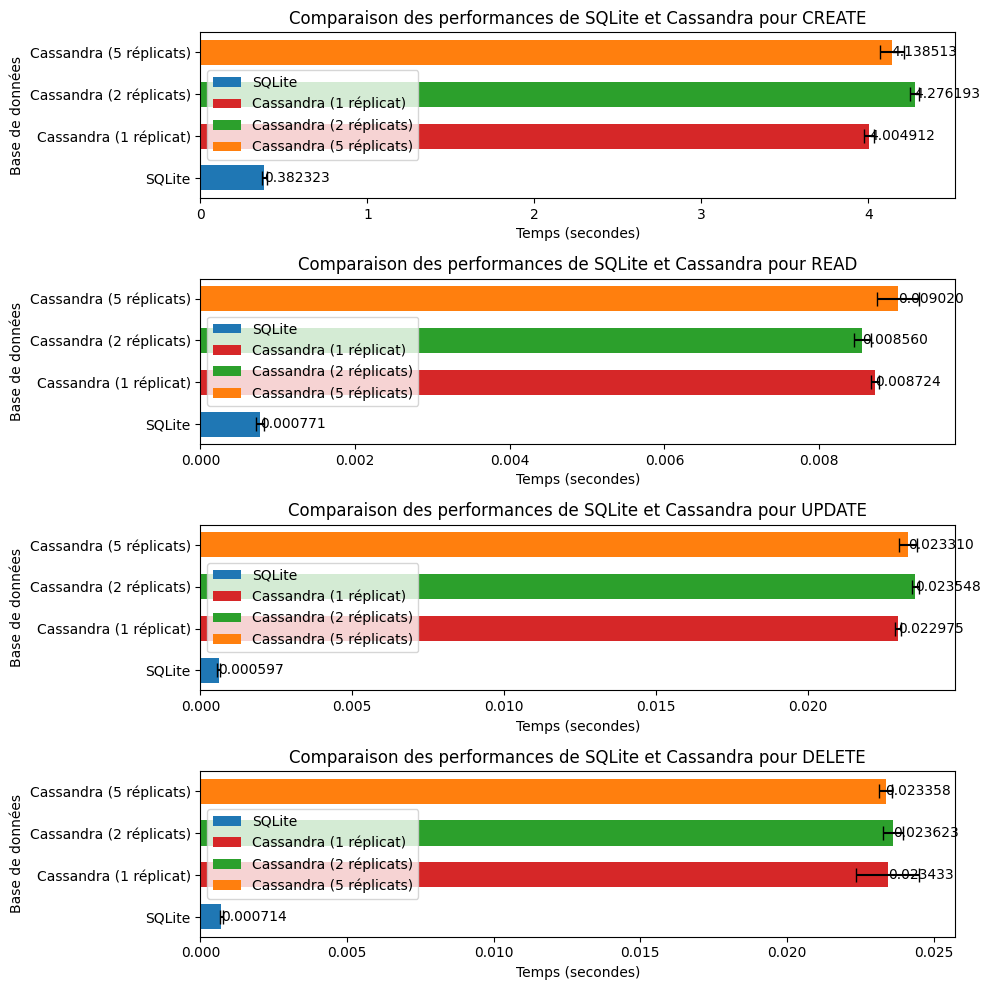

In [28]:
# Données des temps pour SQLite et Cassandra
sqlite_times = {
    'CREATE': (create_sqlite_massive_mean_time, create_sqlite_massive_std_time),
    'READ': (read_sqlite_massive_mean_time, read_sqlite_massive_std_time),
    'UPDATE': (update_sqlite_massive_mean_time, update_sqlite_massive_std_time),
    'DELETE': (delete_sqlite_massive_mean_time, delete_sqlite_massive_std_time)
}

cassandra_times = {
    'CREATE': (create_cas_massive_mean_time, create_cas_massive_std_time),
    'READ': (read_cas_massive_mean_time, read_cas_massive_std_time),
    'UPDATE': (update_cas_massive_mean_time, update_cas_massive_std_time),
    'DELETE': (delete_cas_massive_mean_time, delete_cas_massive_std_time)
}

cassandra_times_2 = {
    'CREATE': (create_cassandra_massive_mean_time_2, create_cassandra_massive_std_time_2),
    'READ': (read_cassandra_massive_mean_time_2, read_cassandra_massive_std_time_2),
    'UPDATE': (update_cassandra_massive_mean_time_2, update_cassandra_massive_std_time_2),
    'DELETE': (delete_cassandra_massive_mean_time_2, delete_cassandra_massive_std_time_2)
}

cassandra_times_5 = {
    'CREATE': (create_cassandra_massive_mean_time_5, create_cassandra_massive_std_time_5),
    'READ': (read_cassandra_massive_mean_time_5, read_cassandra_massive_std_time_5),
    'UPDATE': (update_cassandra_massive_mean_time_5, update_cassandra_massive_std_time_5),
    'DELETE': (delete_cassandra_massive_mean_time_5, delete_cassandra_massive_std_time_5)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Extraire les moyennes et les écarts-types pour chaque opération
sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

cassandra_means_2 = [cassandra_times_2[op][0] for op in operations]
cassandra_stds_2 = [cassandra_times_2[op][1] for op in operations]

cassandra_means_5 = [cassandra_times_5[op][0] for op in operations]
cassandra_stds_5 = [cassandra_times_5[op][1] for op in operations]

# Créer un graphique pour chaque opération
fig, axes = plt.subplots(4, 1, figsize=(10, 10))  # 4 graphiques sous le même format
height = 0.6

# Générer chaque sous-graphe pour chaque opération
for i, op in enumerate(operations):
    ax = axes[i]
    y = np.arange(4)  # Quatre barres par graphique : SQLite, Cassandra (1), (2) et (5) réplicats

    # Dessiner les barres pour SQLite et Cassandra avec différents réplicats
    bars1 = ax.barh(y[0] , sqlite_times[op][0], height, xerr=sqlite_times[op][1], label='SQLite', capsize=5, color='tab:blue')
    bars2 = ax.barh(y[1] , cassandra_times[op][0], height, xerr=cassandra_times[op][1], label='Cassandra (1 réplicat)', capsize=5, color='tab:red')
    bars3 = ax.barh(y[2], cassandra_times_2[op][0], height, xerr=cassandra_times_2[op][1], label='Cassandra (2 réplicats)', capsize=5, color='tab:green')
    bars4 = ax.barh(y[3], cassandra_times_5[op][0], height, xerr=cassandra_times_5[op][1], label='Cassandra (5 réplicats)', capsize=5, color='tab:orange')

    # Titre et labels
    ax.set_xlabel('Temps (secondes)')
    ax.set_ylabel('Base de données')
    ax.set_title(f'Comparaison des performances de SQLite et Cassandra pour {op}')
    ax.set_yticks(y)
    ax.set_yticklabels(['SQLite', 'Cassandra (1 réplicat)', 'Cassandra (2 réplicats)', 'Cassandra (5 réplicats)'])
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)
    add_values(bars3)
    add_values(bars4)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()


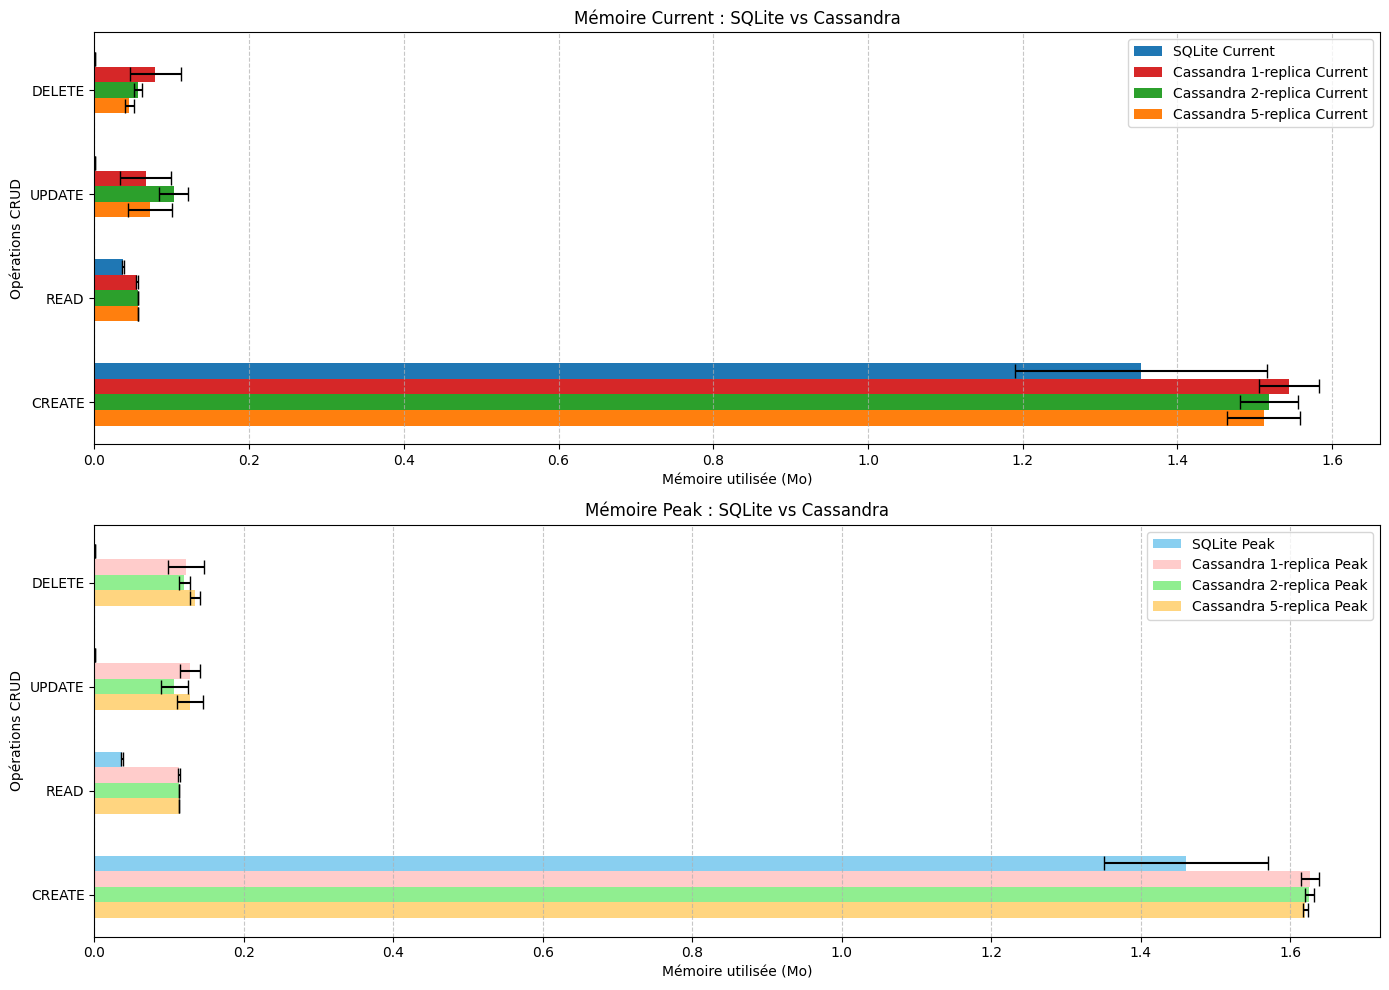

In [29]:
# Valeurs de mémoire pour SQLite
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_massive_mean_current_memory, create_sqlite_massive_std_current_memory),
               'peak': (create_sqlite_massive_mean_peak_memory, create_sqlite_massive_std_peak_memory)},
    'READ': {'current': (read_sqlite_massive_mean_current_memory, read_sqlite_massive_std_current_memory),
             'peak': (read_sqlite_massive_mean_peak_memory, read_sqlite_massive_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_massive_mean_current_memory, update_sqlite_massive_std_current_memory),
               'peak': (update_sqlite_massive_mean_peak_memory, update_sqlite_massive_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_massive_mean_current_memory, delete_sqlite_massive_std_current_memory),
               'peak': (delete_sqlite_massive_mean_peak_memory, delete_sqlite_massive_std_peak_memory)}
}

# Valeurs de mémoire pour Cassandra avec différentes réplications
cassandra_memory = {
    '1-replica': {
        'CREATE': {'current': (create_cas_massive_mean_current_memory, create_cas_massive_std_current_memory),
                   'peak': (create_cas_massive_mean_peak_memory, create_cas_massive_std_peak_memory)},
        'READ': {'current': (read_cas_massive_mean_current_memory, read_cas_massive_std_current_memory),
                 'peak': (read_cas_massive_mean_peak_memory, read_cas_massive_std_peak_memory)},
        'UPDATE': {'current': (update_cas_massive_mean_current_memory, update_cas_massive_std_current_memory),
                   'peak': (update_cas_massive_mean_peak_memory, update_cas_massive_std_peak_memory)},
        'DELETE': {'current': (delete_cas_massive_mean_current_memory, delete_cas_massive_std_current_memory),
                   'peak': (delete_cas_massive_mean_peak_memory, delete_cas_massive_std_peak_memory)}
    },
    '2-replica': {
        'CREATE': {'current': (create_cassandra_massive_mean_current_memory_2, create_cassandra_massive_std_current_memory_2),
                   'peak': (create_cassandra_massive_mean_peak_memory_2, create_cassandra_massive_std_peak_memory_2)},
        'READ': {'current': (read_cassandra_massive_mean_current_memory_2, read_cassandra_massive_std_current_memory_2),
                 'peak': (read_cassandra_massive_mean_peak_memory_2, read_cassandra_massive_std_peak_memory_2)},
        'UPDATE': {'current': (update_cassandra_massive_mean_current_memory_2, update_cassandra_massive_std_current_memory_2),
                   'peak': (update_cassandra_massive_mean_peak_memory_2, update_cassandra_massive_std_peak_memory_2)},
        'DELETE': {'current': (delete_cassandra_massive_mean_current_memory_2, delete_cassandra_massive_std_current_memory_2),
                   'peak': (delete_cassandra_massive_mean_peak_memory_2, delete_cassandra_massive_std_peak_memory_2)}
    },
    '5-replica': {
        'CREATE': {'current': (create_cassandra_massive_mean_current_memory_5, create_cassandra_massive_std_current_memory_5),
                   'peak': (create_cassandra_massive_mean_peak_memory_5, create_cassandra_massive_std_peak_memory_5)},
        'READ': {'current': (read_cassandra_massive_mean_current_memory_5, read_cassandra_massive_std_current_memory_5),
                 'peak': (read_cassandra_massive_mean_peak_memory_5, read_cassandra_massive_std_peak_memory_5)},
        'UPDATE': {'current': (update_cassandra_massive_mean_current_memory_5, update_cassandra_massive_std_current_memory_5),
                   'peak': (update_cassandra_massive_mean_peak_memory_5, update_cassandra_massive_std_peak_memory_5)},
        'DELETE': {'current': (delete_cassandra_massive_mean_current_memory_5, delete_cassandra_massive_std_current_memory_5),
                   'peak': (delete_cassandra_massive_mean_peak_memory_5, delete_cassandra_massive_std_peak_memory_5)}
    }
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Préparation des données
sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = {replica: [cassandra_memory[replica][op]['current'][0] for op in operations] for replica in cassandra_memory}
cassandra_current_stds = {replica: [cassandra_memory[replica][op]['current'][1] for op in operations] for replica in cassandra_memory}
cassandra_peak_means = {replica: [cassandra_memory[replica][op]['peak'][0] for op in operations] for replica in cassandra_memory}
cassandra_peak_stds = {replica: [cassandra_memory[replica][op]['peak'][1] for op in operations] for replica in cassandra_memory}

y = np.arange(len(operations))
height = 0.15

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

colors = ['tab:red', 'tab:green', 'tab:orange']
# Current Memory
ax[0].barh(y + 2 * height, sqlite_current_means, height, xerr=sqlite_current_stds, label='SQLite Current', color='tab:blue', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[0].barh(y + (1 - i) * height, cassandra_current_means[replica], height, xerr=cassandra_current_stds[replica], 
               label=f'Cassandra {replica} Current', capsize=5, color=colors[i])


colors = ['#FFCCCB', '#90EE90', '#FFD580']
# Peak Memory
ax[1].barh(y + 2 * height, sqlite_peak_means, height, xerr=sqlite_peak_stds, label='SQLite Peak', color='#89CFF0', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[1].barh(y + (1 - i) * height, cassandra_peak_means[replica], height, xerr=cassandra_peak_stds[replica], 
               label=f'Cassandra {replica} Peak', capsize=5, color=colors[i])

# Ajustements graphiques
for i in range(2):
    ax[i].set_xlabel('Mémoire utilisée (Mo)')
    ax[i].set_ylabel('Opérations CRUD')
    ax[i].set_yticks(y)
    ax[i].set_yticklabels(operations)
    ax[i].legend()
    ax[i].grid(axis='x', linestyle='--', alpha=0.7)

ax[0].set_title('Mémoire Current : SQLite vs Cassandra')
ax[1].set_title('Mémoire Peak : SQLite vs Cassandra')

plt.tight_layout()
plt.show()


TODO ZOE commenter 

expliquer les temps : 

Pourquoi essayer plusieurs niveaux de réplication ?
Impact sur les performances des lectures : Plus vous avez de répliques, plus Cassandra doit examiner plusieurs nœuds pour répondre à une requête de lecture. Cela peut augmenter la latence en fonction du niveau de réplication et de la manière dont les nœuds sont répartis.
Impact sur les écritures : En fonction de la configuration de réplication, chaque écriture doit être propagée vers plusieurs nœuds. Cela peut augmenter le temps d'insertion ou d'update, surtout en cas de faible cohérence (si un niveau de cohérence faible est choisi).
Tolérance aux pannes : Un nombre plus élevé de répliques permet à Cassandra de maintenir la disponibilité même en cas de panne de certains nœuds. Cependant, cela peut aussi introduire des coûts en termes de latence et de consommation de ressources.

# Création d'un dataset plus grand

Utiliser une base de données plus grande : Cassandra est mieux adapté pour gérer de grandes quantités de données et pour tirer parti de son architecture distribuée.
On va donc augmenter notre jeu de données 

On crée nous même ce dataset car les sites de création de dataset ne permettent de télécharger que 1000 lignes avec un compte gratuit.

In [30]:
df_initial.shape

(8807, 12)

In [31]:
original_df = df_initial 

num_rows = 30000

def generate_large_column(original_column, size):
    return [random.choice(original_column) for _ in range(size)]

def generate_unique_show_id(existing_ids, size):
    start_id = max(existing_ids) + 1 if existing_ids else 1
    return [f"{i}" for i in range(start_id, start_id + size)]

generated_data = original_df.to_dict(orient='list')  

existing_ids = set(map(int, original_df["show_id"].tolist())) 
new_ids = generate_unique_show_id(existing_ids, num_rows - len(original_df))
generated_data["show_id"].extend(new_ids)

for column in original_df.columns:
    if column != "show_id":  
        generated_data[column].extend(generate_large_column(original_df[column].tolist(), num_rows - len(original_df)))

large_df = pd.DataFrame(generated_data)

large_df = large_df.drop_duplicates()

for column in large_df.columns:
    if large_df[column].isnull().any():
        if large_df[column].dtype == "object":
            large_df[column].fillna("Unknown", inplace=True)  
        else:
            large_df[column].fillna(0, inplace=True)  

large_df = large_df.drop_duplicates()

if large_df["show_id"].duplicated().any():
    print("Attention : Des doublons existent dans la colonne 'show_id'.")
else:
    print("Les IDs sont uniques.")

output_file = "netflix_titles_large.csv"
large_df.to_csv(output_file, index=False)
print(f"Dataset généré avec {len(large_df)} lignes (lignes dupliquées supprimées) et exporté dans {output_file}.")


Les IDs sont uniques.
Dataset généré avec 30000 lignes (lignes dupliquées supprimées) et exporté dans netflix_titles_large.csv.


In [32]:
large_df.shape

(30000, 12)

In [33]:
# Caster correctement les colonnes 
large_df['show_id'] = large_df['show_id'].astype(int)

large_df['show_id'] = large_df['show_id'].astype(int)
large_df['release_year'] = large_df['release_year'].astype(int)

large_df['type'] = large_df['title'].astype(str)
large_df['title'] = large_df['title'].astype(str)
large_df['director'] = large_df['director'].astype(str)
large_df['cast'] = large_df['cast'].astype(str)
large_df['country'] = large_df['country'].astype(str)
large_df['date_added'] = large_df['date_added'].astype(str)
large_df['rating'] = large_df['rating'].astype(str)
large_df['duration'] = large_df['duration'].astype(str)
large_df['listed_in'] = large_df['listed_in'].astype(str)
large_df['description'] = large_df['description'].astype(str)

In [34]:
# sqlite 
# --- CREATE ---
create_sqlite_massive_mean_time, create_sqlite_massive_std_time, \
    create_sqlite_massive_mean_current_memory, create_sqlite_massive_std_current_memory, \
        create_sqlite_massive_mean_peak_memory, create_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_insert, large_df)

# --- READ ---
read_sqlite_massive_mean_time, read_sqlite_massive_std_time, \
    read_sqlite_massive_mean_current_memory, read_sqlite_massive_std_current_memory, \
        read_sqlite_massive_mean_peak_memory, read_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_read, large_df)

# --- UPDATE ---
update_sqlite_massive_mean_time, update_sqlite_massive_std_time, \
    update_sqlite_massive_mean_current_memory, update_sqlite_massive_std_current_memory, \
        update_sqlite_massive_mean_peak_memory, update_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_update, large_df)

# --- DELETE ---
delete_sqlite_massive_mean_time, delete_sqlite_massive_std_time, \
    delete_sqlite_massive_mean_current_memory, delete_sqlite_massive_std_current_memory, \
        delete_sqlite_massive_mean_peak_memory, delete_sqlite_massive_std_peak_memory = benchmark_operation(sqlite_delete, large_df)

Create Time: 1.310893 seconds
Current memory usage is 4.345832824707031Mo; Peak was 4.802192687988281Mo
Create Time: 1.293070 seconds
Current memory usage is 4.344351768493652Mo; Peak was 4.80078125Mo
Create Time: 1.304286 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.269991 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.309961 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.337334 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Read Time: 0.002710 seconds
Queried 123 records
Current memory usage is 0.13101863861083984Mo; Peak was 0.13101863861083984Mo
Create Time: 1.339335 seconds
Current memory usage is 4.34409236907959Mo; Peak was 4.80078125Mo
Read Time: 0.002766 seconds
Queried 123 records
Current memory usage is 0.1144094467163086Mo; Peak was 0.1144094467163086Mo
Create Time: 1.315633 seconds
Current memory usage is 4.343848228

In [35]:
# Cassandra

# 1 replica
# --- CREATE ---
create_cas_mean_time, create_cas_std_time, \
    create_cas_mean_current_memory, create_cas_std_current_memory, \
        create_cas_mean_peak_memory, create_cas_std_peak_memory = benchmark_operation(cassandra_insert, large_df, 1)

# --- READ ---
read_cas_mean_time, read_cas_std_time, \
    read_cas_mean_current_memory, read_cas_std_current_memory, \
        read_cas_mean_peak_memory, read_cas_std_peak_memory = benchmark_operation(cassandra_read, large_df, 1)

# --- UPDATE ---
update_cas_mean_time, update_cas_std_time, \
    update_cas_mean_current_memory, update_cas_std_current_memory, \
        update_cas_mean_peak_memory, update_cas_std_peak_memory = benchmark_operation(cassandra_update, large_df, 1)

# --- DELETE ---
delete_cas_mean_time, delete_cas_std_time, \
    delete_cas_mean_current_memory, delete_cas_std_current_memory, \
        delete_cas_mean_peak_memory, delete_cas_std_peak_memory = benchmark_operation(cassandra_delete, large_df, 1)

replication factor = 1
Create Time: 14.230552 seconds
Current memory usage is 4.628091812133789Mo; Peak was 4.870650291442871Mo
replication factor = 1
Create Time: 14.523285 seconds
Current memory usage is 4.797370910644531Mo; Peak was 4.950046539306641Mo
replication factor = 1
Create Time: 14.003788 seconds
Current memory usage is 4.878451347351074Mo; Peak was 4.9391279220581055Mo
replication factor = 1
Create Time: 14.164086 seconds
Current memory usage is 4.783019065856934Mo; Peak was 4.943739891052246Mo
replication factor = 1
Create Time: 16.155736 seconds
Current memory usage is 4.830892562866211Mo; Peak was 4.940912246704102Mo
replication factor = 1
Create Time: 13.810047 seconds
Current memory usage is 4.810578346252441Mo; Peak was 4.9397430419921875Mo
Read Time: 0.031197 seconds
Queried 123 records
Current memory usage is 0.1532001495361328Mo; Peak was 0.33983707427978516Mo
replication factor = 1
Create Time: 13.982105 seconds
Current memory usage is 4.79090690612793Mo; Peak wa

In [36]:
# 2 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_2, create_cassandra_massive_std_time_2, \
    create_cassandra_massive_mean_current_memory_2, create_cassandra_massive_std_current_memory_2, \
        create_cassandra_massive_mean_peak_memory_2, create_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_insert, large_df, 2)

# --- READ ---
read_cassandra_massive_mean_time_2, read_cassandra_massive_std_time_2, \
    read_cassandra_massive_mean_current_memory_2, read_cassandra_massive_std_current_memory_2, \
        read_cassandra_massive_mean_peak_memory_2, read_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_read, large_df, 2)

# --- UPDATE ---
update_cassandra_massive_mean_time_2, update_cassandra_massive_std_time_2, \
    update_cassandra_massive_mean_current_memory_2, update_cassandra_massive_std_current_memory_2, \
        update_cassandra_massive_mean_peak_memory_2, update_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_update, large_df, 2)

# --- DELETE ---
delete_cassandra_massive_mean_time_2, delete_cassandra_massive_std_time_2, \
    delete_cassandra_massive_mean_current_memory_2, delete_cassandra_massive_std_current_memory_2, \
        delete_cassandra_massive_mean_peak_memory_2, delete_cassandra_massive_std_peak_memory_2 = benchmark_operation(cassandra_delete, large_df, 2)


replication factor = 2
Create Time: 14.115720 seconds
Current memory usage is 4.782404899597168Mo; Peak was 4.9356794357299805Mo
replication factor = 2
Create Time: 13.699786 seconds
Current memory usage is 4.899224281311035Mo; Peak was 4.941582679748535Mo
replication factor = 2
Create Time: 13.600495 seconds
Current memory usage is 4.808382987976074Mo; Peak was 4.940110206604004Mo
replication factor = 2
Create Time: 13.667429 seconds
Current memory usage is 4.90312385559082Mo; Peak was 4.935906410217285Mo
replication factor = 2
Create Time: 13.622776 seconds
Current memory usage is 4.817533493041992Mo; Peak was 4.944614410400391Mo
replication factor = 2
Create Time: 13.646119 seconds
Current memory usage is 4.9163312911987305Mo; Peak was 4.962928771972656Mo
Read Time: 0.027969 seconds
Queried 123 records
Current memory usage is 0.15196895599365234Mo; Peak was 0.3386058807373047Mo
replication factor = 2
Create Time: 13.664447 seconds
Current memory usage is 4.906529426574707Mo; Peak wa

In [37]:
# 5 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_5, create_cassandra_massive_std_time_5, \
    create_cassandra_massive_mean_current_memory_5, create_cassandra_massive_std_current_memory_5, \
        create_cassandra_massive_mean_peak_memory_5, create_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_insert, large_df, 5)

# --- READ ---
read_cassandra_massive_mean_time_5, read_cassandra_massive_std_time_5, \
    read_cassandra_massive_mean_current_memory_5, read_cassandra_massive_std_current_memory_5, \
        read_cassandra_massive_mean_peak_memory_5, read_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_read, large_df, 5)

# --- UPDATE ---
update_cassandra_massive_mean_time_5, update_cassandra_massive_std_time_5, \
    update_cassandra_massive_mean_current_memory_5, update_cassandra_massive_std_current_memory_5, \
        update_cassandra_massive_mean_peak_memory_5, update_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_update, large_df, 5)

# --- DELETE ---
delete_cassandra_massive_mean_time_5, delete_cassandra_massive_std_time_5, \
    delete_cassandra_massive_mean_current_memory_5, delete_cassandra_massive_std_current_memory_5, \
        delete_cassandra_massive_mean_peak_memory_5, delete_cassandra_massive_std_peak_memory_5 = benchmark_operation(cassandra_delete, large_df, 5)


replication factor = 5
Create Time: 13.849783 seconds
Current memory usage is 4.888823509216309Mo; Peak was 4.934226036071777Mo
replication factor = 5
Create Time: 13.738757 seconds
Current memory usage is 4.862237930297852Mo; Peak was 4.944633483886719Mo
replication factor = 5
Create Time: 14.041253 seconds
Current memory usage is 4.688407897949219Mo; Peak was 4.828967094421387Mo
replication factor = 5
Create Time: 13.661506 seconds
Current memory usage is 4.891117095947266Mo; Peak was 4.94728946685791Mo
replication factor = 5
Create Time: 13.736337 seconds
Current memory usage is 4.867101669311523Mo; Peak was 4.948338508605957Mo
replication factor = 5
Create Time: 13.858417 seconds
Current memory usage is 4.785381317138672Mo; Peak was 4.949344635009766Mo
Read Time: 0.028056 seconds
Queried 123 records
Current memory usage is 0.15175533294677734Mo; Peak was 0.33896446228027344Mo
replication factor = 5
Create Time: 13.833869 seconds
Current memory usage is 4.762566566467285Mo; Peak was

## Visualisation

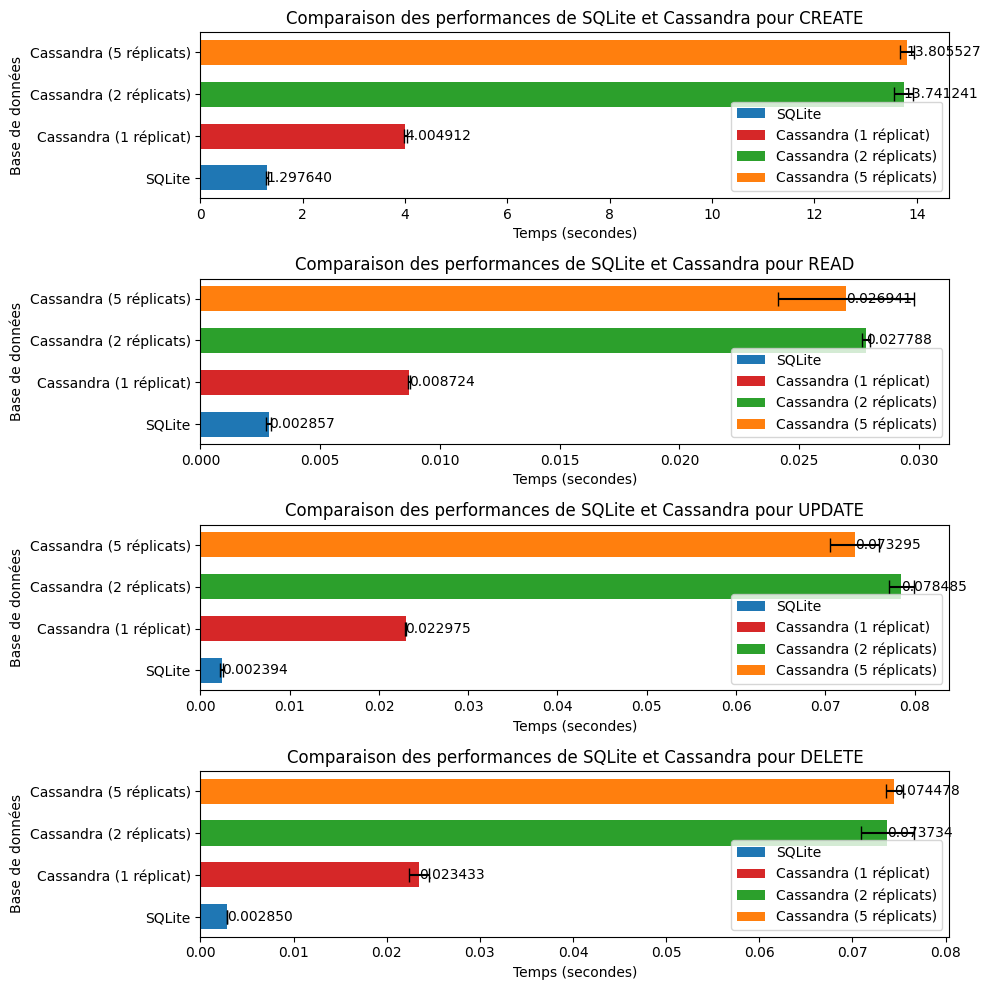

In [38]:
sqlite_times = {
    'CREATE': (create_sqlite_massive_mean_time, create_sqlite_massive_std_time),
    'READ': (read_sqlite_massive_mean_time, read_sqlite_massive_std_time),
    'UPDATE': (update_sqlite_massive_mean_time, update_sqlite_massive_std_time),
    'DELETE': (delete_sqlite_massive_mean_time, delete_sqlite_massive_std_time)
}

cassandra_times = {
    'CREATE': (create_cas_massive_mean_time, create_cas_massive_std_time),
    'READ': (read_cas_massive_mean_time, read_cas_massive_std_time),
    'UPDATE': (update_cas_massive_mean_time, update_cas_massive_std_time),
    'DELETE': (delete_cas_massive_mean_time, delete_cas_massive_std_time)
}

cassandra_times_2 = {
    'CREATE': (create_cassandra_massive_mean_time_2, create_cassandra_massive_std_time_2),
    'READ': (read_cassandra_massive_mean_time_2, read_cassandra_massive_std_time_2),
    'UPDATE': (update_cassandra_massive_mean_time_2, update_cassandra_massive_std_time_2),
    'DELETE': (delete_cassandra_massive_mean_time_2, delete_cassandra_massive_std_time_2)
}

cassandra_times_5 = {
    'CREATE': (create_cassandra_massive_mean_time_5, create_cassandra_massive_std_time_5),
    'READ': (read_cassandra_massive_mean_time_5, read_cassandra_massive_std_time_5),
    'UPDATE': (update_cassandra_massive_mean_time_5, update_cassandra_massive_std_time_5),
    'DELETE': (delete_cassandra_massive_mean_time_5, delete_cassandra_massive_std_time_5)
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Extraire les temps moyens et écarts-types pour chaque système
sqlite_means = [sqlite_times[op][0] for op in operations]
sqlite_stds = [sqlite_times[op][1] for op in operations]

cassandra_means = [cassandra_times[op][0] for op in operations]
cassandra_stds = [cassandra_times[op][1] for op in operations]

cassandra_means_2 = [cassandra_times_2[op][0] for op in operations]
cassandra_stds_2 = [cassandra_times_2[op][1] for op in operations]

cassandra_means_5 = [cassandra_times_5[op][0] for op in operations]
cassandra_stds_5 = [cassandra_times_5[op][1] for op in operations]

# Créer un graphique pour chaque opération
fig, axes = plt.subplots(4, 1, figsize=(10, 10))  # 4 graphiques sous le même format
height = 0.6

# Générer chaque sous-graphe pour chaque opération
for i, op in enumerate(operations):
    ax = axes[i]
    y = np.arange(4)  # Quatre barres par graphique : SQLite, Cassandra (1), (2) et (5) réplicats

    # Dessiner les barres pour SQLite et Cassandra avec différents réplicats
    bars1 = ax.barh(y[0] , sqlite_times[op][0], height, xerr=sqlite_times[op][1], label='SQLite', capsize=5, color='tab:blue')
    bars2 = ax.barh(y[1] , cassandra_times[op][0], height, xerr=cassandra_times[op][1], label='Cassandra (1 réplicat)', capsize=5, color='tab:red')
    bars3 = ax.barh(y[2], cassandra_times_2[op][0], height, xerr=cassandra_times_2[op][1], label='Cassandra (2 réplicats)', capsize=5, color='tab:green')
    bars4 = ax.barh(y[3], cassandra_times_5[op][0], height, xerr=cassandra_times_5[op][1], label='Cassandra (5 réplicats)', capsize=5, color='tab:orange')

    # Titre et labels
    ax.set_xlabel('Temps (secondes)')
    ax.set_ylabel('Base de données')
    ax.set_title(f'Comparaison des performances de SQLite et Cassandra pour {op}')
    ax.set_yticks(y)
    ax.set_yticklabels(['SQLite', 'Cassandra (1 réplicat)', 'Cassandra (2 réplicats)', 'Cassandra (5 réplicats)'])
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)
    add_values(bars3)
    add_values(bars4)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()


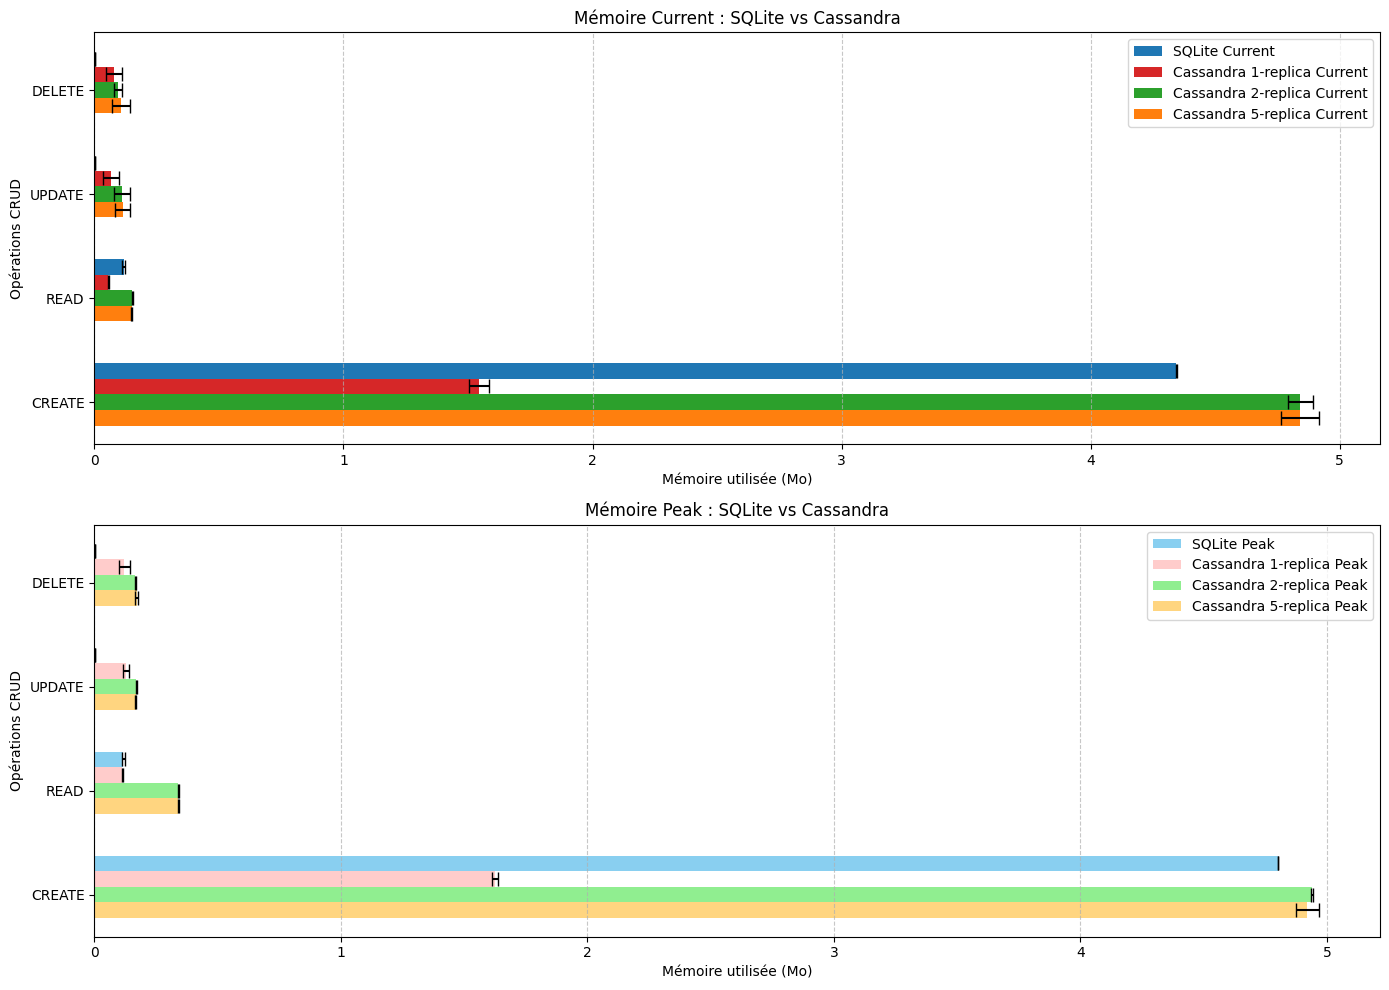

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Valeurs de mémoire pour SQLite
sqlite_memory = {
    'CREATE': {'current': (create_sqlite_massive_mean_current_memory, create_sqlite_massive_std_current_memory),
               'peak': (create_sqlite_massive_mean_peak_memory, create_sqlite_massive_std_peak_memory)},
    'READ': {'current': (read_sqlite_massive_mean_current_memory, read_sqlite_massive_std_current_memory),
             'peak': (read_sqlite_massive_mean_peak_memory, read_sqlite_massive_std_peak_memory)},
    'UPDATE': {'current': (update_sqlite_massive_mean_current_memory, update_sqlite_massive_std_current_memory),
               'peak': (update_sqlite_massive_mean_peak_memory, update_sqlite_massive_std_peak_memory)},
    'DELETE': {'current': (delete_sqlite_massive_mean_current_memory, delete_sqlite_massive_std_current_memory),
               'peak': (delete_sqlite_massive_mean_peak_memory, delete_sqlite_massive_std_peak_memory)}
}

# Valeurs de mémoire pour Cassandra avec différentes réplications
cassandra_memory = {
    '1-replica': {
        'CREATE': {'current': (create_cas_massive_mean_current_memory, create_cas_massive_std_current_memory),
                   'peak': (create_cas_massive_mean_peak_memory, create_cas_massive_std_peak_memory)},
        'READ': {'current': (read_cas_massive_mean_current_memory, read_cas_massive_std_current_memory),
                 'peak': (read_cas_massive_mean_peak_memory, read_cas_massive_std_peak_memory)},
        'UPDATE': {'current': (update_cas_massive_mean_current_memory, update_cas_massive_std_current_memory),
                   'peak': (update_cas_massive_mean_peak_memory, update_cas_massive_std_peak_memory)},
        'DELETE': {'current': (delete_cas_massive_mean_current_memory, delete_cas_massive_std_current_memory),
                   'peak': (delete_cas_massive_mean_peak_memory, delete_cas_massive_std_peak_memory)}
    },
    '2-replica': {
        'CREATE': {'current': (create_cassandra_massive_mean_current_memory_2, create_cassandra_massive_std_current_memory_2),
                   'peak': (create_cassandra_massive_mean_peak_memory_2, create_cassandra_massive_std_peak_memory_2)},
        'READ': {'current': (read_cassandra_massive_mean_current_memory_2, read_cassandra_massive_std_current_memory_2),
                 'peak': (read_cassandra_massive_mean_peak_memory_2, read_cassandra_massive_std_peak_memory_2)},
        'UPDATE': {'current': (update_cassandra_massive_mean_current_memory_2, update_cassandra_massive_std_current_memory_2),
                   'peak': (update_cassandra_massive_mean_peak_memory_2, update_cassandra_massive_std_peak_memory_2)},
        'DELETE': {'current': (delete_cassandra_massive_mean_current_memory_2, delete_cassandra_massive_std_current_memory_2),
                   'peak': (delete_cassandra_massive_mean_peak_memory_2, delete_cassandra_massive_std_peak_memory_2)}
    },
    '5-replica': {
        'CREATE': {'current': (create_cassandra_massive_mean_current_memory_5, create_cassandra_massive_std_current_memory_5),
                   'peak': (create_cassandra_massive_mean_peak_memory_5, create_cassandra_massive_std_peak_memory_5)},
        'READ': {'current': (read_cassandra_massive_mean_current_memory_5, read_cassandra_massive_std_current_memory_5),
                 'peak': (read_cassandra_massive_mean_peak_memory_5, read_cassandra_massive_std_peak_memory_5)},
        'UPDATE': {'current': (update_cassandra_massive_mean_current_memory_5, update_cassandra_massive_std_current_memory_5),
                   'peak': (update_cassandra_massive_mean_peak_memory_5, update_cassandra_massive_std_peak_memory_5)},
        'DELETE': {'current': (delete_cassandra_massive_mean_current_memory_5, delete_cassandra_massive_std_current_memory_5),
                   'peak': (delete_cassandra_massive_mean_peak_memory_5, delete_cassandra_massive_std_peak_memory_5)}
    }
}

operations = ['CREATE', 'READ', 'UPDATE', 'DELETE']

# Préparation des données
sqlite_current_means = [sqlite_memory[op]['current'][0] for op in operations]
sqlite_current_stds = [sqlite_memory[op]['current'][1] for op in operations]
sqlite_peak_means = [sqlite_memory[op]['peak'][0] for op in operations]
sqlite_peak_stds = [sqlite_memory[op]['peak'][1] for op in operations]

cassandra_current_means = {replica: [cassandra_memory[replica][op]['current'][0] for op in operations] for replica in cassandra_memory}
cassandra_current_stds = {replica: [cassandra_memory[replica][op]['current'][1] for op in operations] for replica in cassandra_memory}
cassandra_peak_means = {replica: [cassandra_memory[replica][op]['peak'][0] for op in operations] for replica in cassandra_memory}
cassandra_peak_stds = {replica: [cassandra_memory[replica][op]['peak'][1] for op in operations] for replica in cassandra_memory}

y = np.arange(len(operations))
height = 0.15

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

colors = ['tab:red', 'tab:green', 'tab:orange']
# Current Memory
ax[0].barh(y + 2 * height, sqlite_current_means, height, xerr=sqlite_current_stds, label='SQLite Current', color='tab:blue', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[0].barh(y + (1 - i) * height, cassandra_current_means[replica], height, xerr=cassandra_current_stds[replica], 
               label=f'Cassandra {replica} Current', capsize=5, color=colors[i])


colors = ['#FFCCCB', '#90EE90', '#FFD580']
# Peak Memory
ax[1].barh(y + 2 * height, sqlite_peak_means, height, xerr=sqlite_peak_stds, label='SQLite Peak', color='#89CFF0', capsize=5)
for i, replica in enumerate(cassandra_memory):
    ax[1].barh(y + (1 - i) * height, cassandra_peak_means[replica], height, xerr=cassandra_peak_stds[replica], 
               label=f'Cassandra {replica} Peak', capsize=5, color=colors[i])

# Ajustements graphiques
for i in range(2):
    ax[i].set_xlabel('Mémoire utilisée (Mo)')
    ax[i].set_ylabel('Opérations CRUD')
    ax[i].set_yticks(y)
    ax[i].set_yticklabels(operations)
    ax[i].legend()
    ax[i].grid(axis='x', linestyle='--', alpha=0.7)

ax[0].set_title('Mémoire Current : SQLite vs Cassandra')
ax[1].set_title('Mémoire Peak : SQLite vs Cassandra')

plt.tight_layout()
plt.show()


TODO ZOE commenter ZOE la visualisation aussi 

# Comparaison avec / sans index

### Index secondaires (clés secondaires)


Dans Cassandra, la commande `CREATE INDEX` permet de créer des index secondaires, qui ne sont pas des clés primaires. Cela permet de filtrer les données sur des colonnes autres que la partition key ou les clustering keys.

#### Avantages des index secondaires

- Facilite les filtres sur des colonnes non clés : Vous pouvez filtrer sur des colonnes autres que la partition key ou les clustering keys, ce qui rend les requêtes plus flexibles.
- Accès plus rapide aux données : Les index secondaires optimisent les requêtes qui filtrent sur certaines colonnes spécifiques, réduisant le nombre de partitions à examiner.

#### Inconvénients des index secondaires

- Risque de surcharge de performance : Sur de grandes tables, si une colonne contient beaucoup de valeurs distinctes, l'index peut devenir lourd et ralentir les performances des écritures et lectures.
- Structure distribuée moins efficace : Les index secondaires sont distribués, mais leur gestion est moins performante que les clés primaires, surtout sur des colonnes avec une haute cardinalité.
- Limitations d'usage : Les index secondaires sont mieux utilisés sur des colonnes avec faible cardinalité. Il est déconseillé de les utiliser pour des colonnes ayant une forte cardinalité ou pour des filtres complexes impliquant plusieurs colonnes.
- `ALLOW FILTERING` : Parfois, pour exécuter une requête avec un index secondaire (utilisation de `<` ou `>` par exemple), il est obligatoire d'utiliser `ALLOW FILTERING`, ce qui peut nuire aux performances en scannant une grande partie des données.

In [40]:
def cassandra_create_indexes(columns):
    tracemalloc.start()
    start_time = time.time()
    for column in columns:
        index_query = f"CREATE INDEX {column}_idx ON shows ({column});"
        session.execute(index_query)
    cassandra_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    return cassandra_time, current, peak


def sqlite_create_indexes(columns):
    # drop les index
    for column in columns:
        index_query = f"DROP INDEX IF EXISTS {column}_idx;"
        cursor.execute(index_query)

    tracemalloc.start()
    start_time = time.time()
    for column in columns:
        # Créer une requête SQL pour chaque colonne
        index_query = f"CREATE INDEX IF NOT EXISTS {column}_idx ON shows ({column});"
        cursor.execute(index_query)
    sqlite_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    return sqlite_time, current, peak

columns_to_index = ["release_year"]
cassandra_time_index, cassandra_current_index, cassandra_peak_index = cassandra_create_indexes(columns_to_index)
sqlite_time_index, sqlite_current_index, sqlite_peak_index = sqlite_create_indexes(columns_to_index)

print(f"Indexation time: Cassandra {cassandra_time_index:.5f}s, SQLite {sqlite_time_index:.5f}s")
print(f"Current memory: Cassandra {cassandra_current_index:.5f}Mo, SQLite {sqlite_current_index:.5f}Mo")

Indexation time: Cassandra 0.12281s, SQLite 0.00868s
Current memory: Cassandra 0.04005Mo, SQLite 0.00044Mo


In [41]:
# Fonctions pour CRUD SQLite avec index

# --- CREATE ---
def sqlite_insert_index(df):
    drop_table_sqlite()
    create_table_sqlite()
    sqlite_create_indexes(columns_to_index)

    columns = ', '.join(df.columns)
    placeholders = ', '.join(['?'] * len(df.columns))
    insert_query = f"INSERT INTO shows ({columns}) VALUES ({placeholders})"

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
      cursor.execute(insert_query, tuple(row))
    conn.commit()

    create_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Create Time: {create_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return create_time_sqlite, current, peak

# --- READ ---
def sqlite_read_index(df):
    sqlite_insert_index(df)
    tracemalloc.start()
    start_time = time.time()
    cursor.execute("SELECT * FROM shows WHERE release_year = 2000")
    result = cursor.fetchall()
    read_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read Time: {read_time_sqlite:.6f} seconds")
    print(f"Queried {len(result)} records")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time_sqlite, current, peak

# --- UPDATE ---
def sqlite_update_index(df):
    sqlite_insert_index(df)
    tracemalloc.start()
    start_time = time.time()
    cursor.execute("UPDATE shows SET rating='PG' WHERE release_year = 2000")
    conn.commit()
    update_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Update Time: {update_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time_sqlite, current, peak

# --- DELETE ---
def sqlite_delete_index(df):
    sqlite_insert_index(df)
    tracemalloc.start()
    start_time = time.time()
    cursor.execute("DELETE FROM shows WHERE release_year = 2000")
    conn.commit()
    delete_time_sqlite = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete Time: {delete_time_sqlite:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time_sqlite, current, peak

In [42]:
# Fonctions pour CRUD Cassandra avec index

# --- CREATE ---
def cassandra_insert_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques

    drop_table_cassandra()
    create_table_cassandra(nb_repl)
    cassandra_create_indexes(columns_to_index)

    insert_query = session.prepare("INSERT INTO shows (show_id, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)")

    tracemalloc.start()
    start_time = time.time()
    for _, row in df.iterrows():
        session.execute(insert_query, (row['show_id'], row['title'], row['director'], row['cast'], row['country'], row['date_added'], row['release_year'], row['rating'], row['duration'], row['listed_in'], row['description']))
    create_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()

    print(f"Create Time: {create_time:.6f} seconds")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")

    return create_time, current, peak


# --- READ ---
def cassandra_read_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    result = session.execute('SELECT * FROM shows WHERE release_year = 2000 ;') # ici pas de allow filtering !
    read_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Read time with index: {read_time:.5f}s")
    num_records = sum(1 for _ in result)
    print(f"Number of records: {num_records}")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return read_time, current, peak

# Dans Cassandra, pour effectuer un UPDATE, il est nécessaire de spécifier la clé primaire complète (partition key + clustering key).
# Par conséquent, il n'est pas possible de mettre à jour des lignes en fonction de critères de recherche arbitraires, sauf si ces critères correspondent exactement à la clé primaire.

# --- UPDATE ---
def cassandra_update_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    select_query = "SELECT show_id FROM shows WHERE release_year = 2000;"
    result = session.execute(select_query)
    show_ids_to_update = [row.show_id for row in result]
    for show_id in show_ids_to_update:
        update_query = f"UPDATE shows SET rating = 'PG' WHERE show_id = {show_id};"
        session.execute(update_query)
    update_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Update time with index: {update_time:.5f}s")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return update_time, current, peak


# --- DELETE ---
def cassandra_delete_index(*args):
    df = args[0]  # Premier argument, qui est le DataFrame
    nb_repl = args[1]  # Deuxième argument, qui est le nombre de répliques
    cassandra_insert_index(df, nb_repl)

    tracemalloc.start()
    start_time = time.time()
    select_query = "SELECT show_id FROM shows WHERE release_year = 2000;"
    result = session.execute(select_query)
    show_ids_to_delete = [row.show_id for row in result]
    for show_id in show_ids_to_delete:
        delete_query = f"DELETE FROM shows WHERE show_id = {show_id};"
        session.execute(delete_query)
    delete_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    current = current / 1024 / 1024
    peak = peak / 1024 / 1024
    tracemalloc.stop()
    print(f"Delete time with index: {delete_time:.5f}s")
    print(f"Current memory usage is {current}Mo; Peak was {peak}Mo")
    return delete_time, current, peak

In [43]:
# sqlite 
# --- CREATE ---
create_sqlite_massive_mean_time_index, create_sqlite_massive_std_time_index, \
    create_sqlite_massive_mean_current_memory_index, create_sqlite_massive_std_current_memory_index, \
        create_sqlite_massive_mean_peak_memory_index, create_sqlite_massive_std_peak_memory_index = benchmark_operation(sqlite_insert_index, large_df)

# --- READ ---
read_sqlite_massive_mean_time_index, read_sqlite_massive_std_time_index, \
    read_sqlite_massive_mean_current_memory_index, read_sqlite_massive_std_current_memory_index, \
        read_sqlite_massive_mean_peak_memory_index, read_sqlite_massive_std_peak_memory_index = benchmark_operation(sqlite_read_index, large_df)

# --- UPDATE ---
update_sqlite_massive_mean_time_index, update_sqlite_massive_std_time_index, \
    update_sqlite_massive_mean_current_memory_index, update_sqlite_massive_std_current_memory_index, \
        update_sqlite_massive_mean_peak_memory_index, update_sqlite_massive_std_peak_memory_index = benchmark_operation(sqlite_update_index, large_df)

# --- DELETE ---
delete_sqlite_massive_mean_time_index, delete_sqlite_massive_std_time_index, \
    delete_sqlite_massive_mean_current_memory_index, delete_sqlite_massive_std_current_memory_index, \
        delete_sqlite_massive_mean_peak_memory_index, delete_sqlite_massive_std_peak_memory_index = benchmark_operation(sqlite_delete_index, large_df)

Create Time: 1.356941 seconds
Current memory usage is 4.343868255615234Mo; Peak was 4.80078125Mo
Create Time: 1.338595 seconds
Current memory usage is 4.377297401428223Mo; Peak was 4.80078125Mo
Create Time: 1.331852 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.326202 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.322771 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Create Time: 1.372079 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Read Time: 0.000855 seconds
Queried 123 records
Current memory usage is 0.1308736801147461Mo; Peak was 0.1308736801147461Mo
Create Time: 1.439841 seconds
Current memory usage is 4.343626976013184Mo; Peak was 4.80078125Mo
Read Time: 0.000943 seconds
Queried 123 records
Current memory usage is 0.1144094467163086Mo; Peak was 0.1144094467163086Mo
Create Time: 1.365962 seconds
Current memory usage is 4.343626976013184Mo

In [44]:
# Cassandra

# 1 replica
# --- CREATE ---
create_cassandra_mean_time_index, create_cassandra_std_time_index, \
    create_cassandra_mean_current_memory_index, create_cassandra_std_current_memory_index, \
        create_cassandra_mean_peak_memory_index, create_cassandra_std_peak_memory_index = benchmark_operation(cassandra_insert_index, large_df, 1)

# --- READ ---
read_cassandra_mean_time_index, read_cassandra_std_time_index, \
    read_cassandra_mean_current_memory_index, read_cassandra_std_current_memory_index, \
        read_cassandra_mean_peak_memory_index, read_cassandra_std_peak_memory_index = benchmark_operation(cassandra_read_index, large_df, 1)

# --- UPDATE ---
update_cassandra_mean_time_index, update_cassandra_std_time_index, \
    update_cassandra_mean_current_memory_index, update_cassandra_std_current_memory_index, \
        update_cassandra_mean_peak_memory_index, update_cassandra_std_peak_memory_index = benchmark_operation(cassandra_update_index, large_df, 1)

# --- DELETE ---
delete_cassandra_mean_time_index, delete_cassandra_std_time_index, \
    delete_cassandra_mean_current_memory_index, delete_cassandra_std_current_memory_index, \
        delete_cassandra_mean_peak_memory_index, delete_cassandra_std_peak_memory_index = benchmark_operation(cassandra_delete_index, large_df, 1)

replication factor = 1
Create Time: 14.619742 seconds
Current memory usage is 4.876422882080078Mo; Peak was 4.955362319946289Mo
replication factor = 1
Create Time: 13.886787 seconds
Current memory usage is 4.911523818969727Mo; Peak was 4.948952674865723Mo
replication factor = 1
Create Time: 13.938157 seconds
Current memory usage is 4.882994651794434Mo; Peak was 4.956978797912598Mo
replication factor = 1
Create Time: 13.900851 seconds
Current memory usage is 4.813831329345703Mo; Peak was 4.946264266967773Mo
replication factor = 1
Create Time: 13.788701 seconds
Current memory usage is 4.810479164123535Mo; Peak was 4.941247940063477Mo
replication factor = 1
Create Time: 14.191787 seconds
Current memory usage is 4.8095550537109375Mo; Peak was 4.975987434387207Mo
Read time with index: 0.00549s
Number of records: 123
Current memory usage is 0.1523275375366211Mo; Peak was 0.33896446228027344Mo
replication factor = 1
Create Time: 13.972718 seconds
Current memory usage is 4.809176445007324Mo; P

In [45]:
# 2 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_2_index, create_cassandra_massive_std_time_2_index, \
    create_cassandra_massive_mean_current_memory_2_index, create_cassandra_massive_std_current_memory_2_index, \
        create_cassandra_massive_mean_peak_memory_2_index, create_cassandra_massive_std_peak_memory_2_index = benchmark_operation(cassandra_insert_index, large_df, 2)

# --- READ ---
read_cassandra_massive_mean_time_2_index, read_cassandra_massive_std_time_2_index, \
    read_cassandra_massive_mean_current_memory_2_index, read_cassandra_massive_std_current_memory_2_index, \
        read_cassandra_massive_mean_peak_memory_2_index, read_cassandra_massive_std_peak_memory_2_index = benchmark_operation(cassandra_read_index, large_df, 2)

# --- UPDATE ---
update_cassandra_massive_mean_time_2_index, update_cassandra_massive_std_time_2_index, \
    update_cassandra_massive_mean_current_memory_2_index, update_cassandra_massive_std_current_memory_2_index, \
        update_cassandra_massive_mean_peak_memory_2_index, update_cassandra_massive_std_peak_memory_2_index = benchmark_operation(cassandra_update_index, large_df, 2)

# --- DELETE ---
delete_cassandra_massive_mean_time_2_index, delete_cassandra_massive_std_time_2_index, \
    delete_cassandra_massive_mean_current_memory_2_index, delete_cassandra_massive_std_current_memory_2_index, \
        delete_cassandra_massive_mean_peak_memory_2_index, delete_cassandra_massive_std_peak_memory_2_index = benchmark_operation(cassandra_delete_index, large_df, 2)


replication factor = 2
Create Time: 13.826785 seconds
Current memory usage is 4.82502555847168Mo; Peak was 4.94996452331543Mo
replication factor = 2
Create Time: 14.173883 seconds
Current memory usage is 4.911373138427734Mo; Peak was 4.948836326599121Mo
replication factor = 2
Create Time: 14.110115 seconds
Current memory usage is 4.879690170288086Mo; Peak was 4.95421028137207Mo
replication factor = 2
Create Time: 13.982030 seconds
Current memory usage is 4.883364677429199Mo; Peak was 4.942746162414551Mo
replication factor = 2
Create Time: 14.080667 seconds
Current memory usage is 4.8420305252075195Mo; Peak was 4.951737403869629Mo
replication factor = 2
Create Time: 14.114298 seconds
Current memory usage is 4.783389091491699Mo; Peak was 4.949672698974609Mo
Read time with index: 0.00530s
Number of records: 123
Current memory usage is 0.15239620208740234Mo; Peak was 0.33960533142089844Mo
replication factor = 2
Create Time: 13.985129 seconds
Current memory usage is 4.8690032958984375Mo; Pe

In [46]:
# 5 replicas
# --- CREATE ---
create_cassandra_massive_mean_time_5_index, create_cassandra_massive_std_time_5_index, \
    create_cassandra_massive_mean_current_memory_5_index, create_cassandra_massive_std_current_memory_5_index, \
        create_cassandra_massive_mean_peak_memory_5_index, create_cassandra_massive_std_peak_memory_5_index = benchmark_operation(cassandra_insert_index, large_df, 5)

# --- READ ---
read_cassandra_massive_mean_time_5_index, read_cassandra_massive_std_time_5_index, \
    read_cassandra_massive_mean_current_memory_5_index, read_cassandra_massive_std_current_memory_5_index, \
        read_cassandra_massive_mean_peak_memory_5_index, read_cassandra_massive_std_peak_memory_5_index = benchmark_operation(cassandra_read_index, large_df, 5)

# --- UPDATE ---
update_cassandra_massive_mean_time_5_index, update_cassandra_massive_std_time_5_index, \
    update_cassandra_massive_mean_current_memory_5_index, update_cassandra_massive_std_current_memory_5_index, \
        update_cassandra_massive_mean_peak_memory_5_index, update_cassandra_massive_std_peak_memory_5_index = benchmark_operation(cassandra_update_index, large_df, 5)

# --- DELETE ---
delete_cassandra_massive_mean_time_5_index, delete_cassandra_massive_std_time_5_index, \
    delete_cassandra_massive_mean_current_memory_5_index, delete_cassandra_massive_std_current_memory_5_index, \
        delete_cassandra_massive_mean_peak_memory_5_index, delete_cassandra_massive_std_peak_memory_5_index = benchmark_operation(cassandra_delete_index, large_df, 5)

replication factor = 5
Create Time: 14.208763 seconds
Current memory usage is 4.840359687805176Mo; Peak was 4.9366607666015625Mo
replication factor = 5
Create Time: 14.384803 seconds
Current memory usage is 4.964742660522461Mo; Peak was 5.015462875366211Mo
replication factor = 5
Create Time: 14.114207 seconds
Current memory usage is 4.914432525634766Mo; Peak was 4.948467254638672Mo
replication factor = 5
Create Time: 14.011836 seconds
Current memory usage is 4.870566368103027Mo; Peak was 4.944547653198242Mo
replication factor = 5
Create Time: 13.933021 seconds
Current memory usage is 4.834792137145996Mo; Peak was 4.958433151245117Mo
replication factor = 5
Create Time: 13.955088 seconds
Current memory usage is 4.844942092895508Mo; Peak was 4.956388473510742Mo
Read time with index: 0.00540s
Number of records: 123
Current memory usage is 0.15428829193115234Mo; Peak was 0.34070396423339844Mo
replication factor = 5
Create Time: 13.977302 seconds
Current memory usage is 4.880039215087891Mo; 

### Visualisation

##### Comparaison des temps avec et sans index

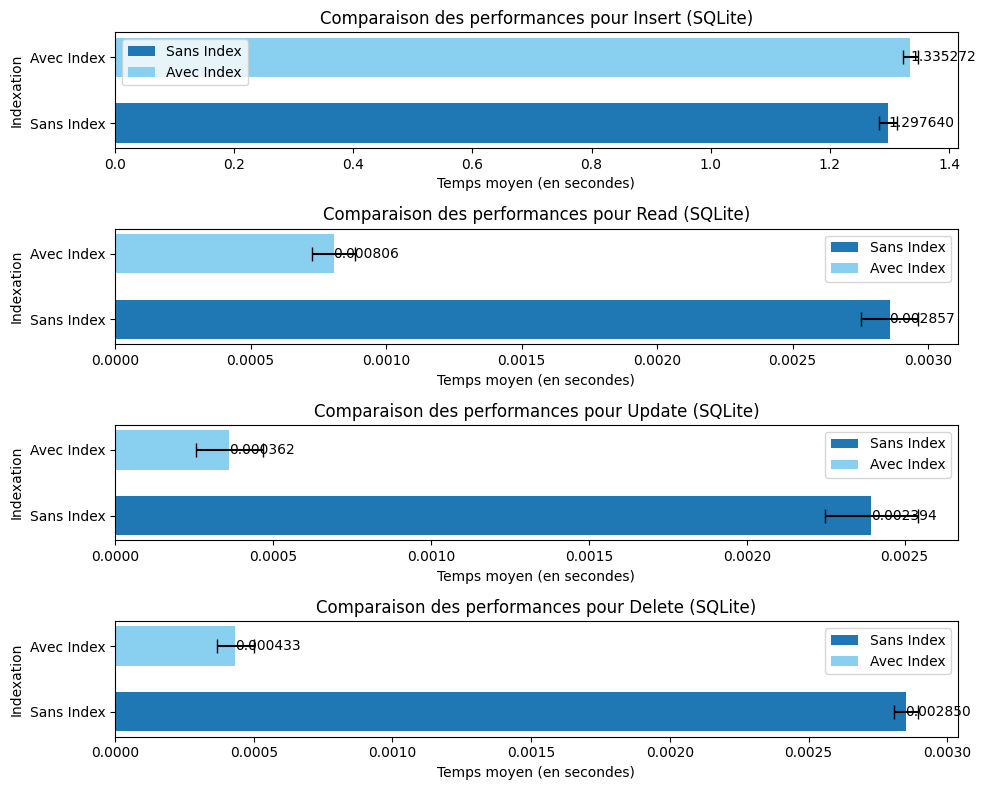

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Actions et temps moyens pour SQLite avec et sans index
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_sqlite_massive_mean_time, read_sqlite_massive_mean_time, 
                      update_sqlite_massive_mean_time, delete_sqlite_massive_mean_time]
mean_with_index = [create_sqlite_massive_mean_time_index, read_sqlite_massive_mean_time_index, 
                   update_sqlite_massive_mean_time_index, delete_sqlite_massive_mean_time_index]

std_without_index = [create_sqlite_massive_std_time, read_sqlite_massive_std_time, 
                     update_sqlite_massive_std_time, delete_sqlite_massive_std_time]
std_with_index = [create_sqlite_massive_std_time_index, read_sqlite_massive_std_time_index, 
                  update_sqlite_massive_std_time_index, delete_sqlite_massive_std_time_index]

# Créer un graphique pour chaque action
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 4 graphiques sous le même format
width = 0.6

# Générer chaque sous-graphe pour chaque action
for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(2)  # 2 barres par graphique : Sans index, Avec index
    mean_values = [mean_without_index[i], mean_with_index[i]]
    std_values = [std_without_index[i], std_with_index[i]]

    # Dessiner les barres pour chaque action
    bars1 = ax.barh(x[0], mean_values[0], width, xerr=std_values[0], label='Sans Index', capsize=5, color='tab:blue')
    bars2 = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Avec Index', capsize=5, color='#89CFF0')

    # Titre et labels
    ax.set_xlabel('Temps moyen (en secondes)')
    ax.set_ylabel('Indexation')
    ax.set_title(f'Comparaison des performances pour {action} (SQLite)')
    ax.set_yticks(x)
    ax.set_yticklabels(['Sans Index', 'Avec Index'])
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()


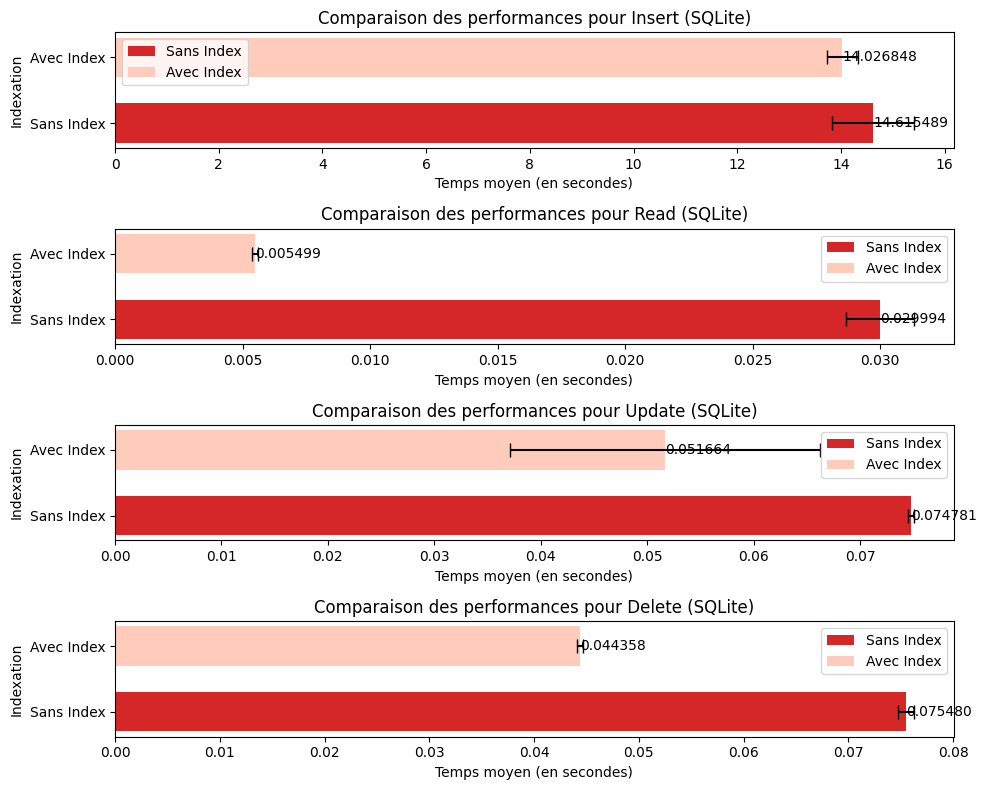

In [ ]:
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_cas_mean_time, read_cas_mean_time, 
                      update_cas_mean_time, delete_cas_mean_time]
mean_with_index = [create_cassandra_mean_time_index, read_cassandra_mean_time_index, 
                   update_cassandra_mean_time_index, delete_cassandra_mean_time_index]

std_without_index = [create_cas_std_time, read_cas_std_time, 
                     update_cas_std_time, delete_cas_std_time]
std_with_index = [create_cassandra_std_time_index, read_cassandra_std_time_index, 
                  update_cassandra_std_time_index, delete_cassandra_std_time_index]

# Créer un graphique pour chaque action
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 4 graphiques sous le même format
width = 0.6

# Générer chaque sous-graphe pour chaque action
for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(2)  # 2 barres par graphique : Sans index, Avec index
    mean_values = [mean_without_index[i], mean_with_index[i]]
    std_values = [std_without_index[i], std_with_index[i]]

    # Dessiner les barres pour chaque action
    bars1 = ax.barh(x[0], mean_values[0], width, xerr=std_values[0], label='Sans Index', capsize=5, color='tab:red')
    bars2 = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Avec Index', capsize=5, color='#FFCCBB')

    # Titre et labels
    ax.set_xlabel('Temps moyen (en secondes)')
    ax.set_ylabel('Indexation')
    ax.set_title(f'Comparaison des performances pour {action} (Cassandra 1 réplicat)')
    ax.set_yticks(x)
    ax.set_yticklabels(['Sans Index', 'Avec Index'])
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()

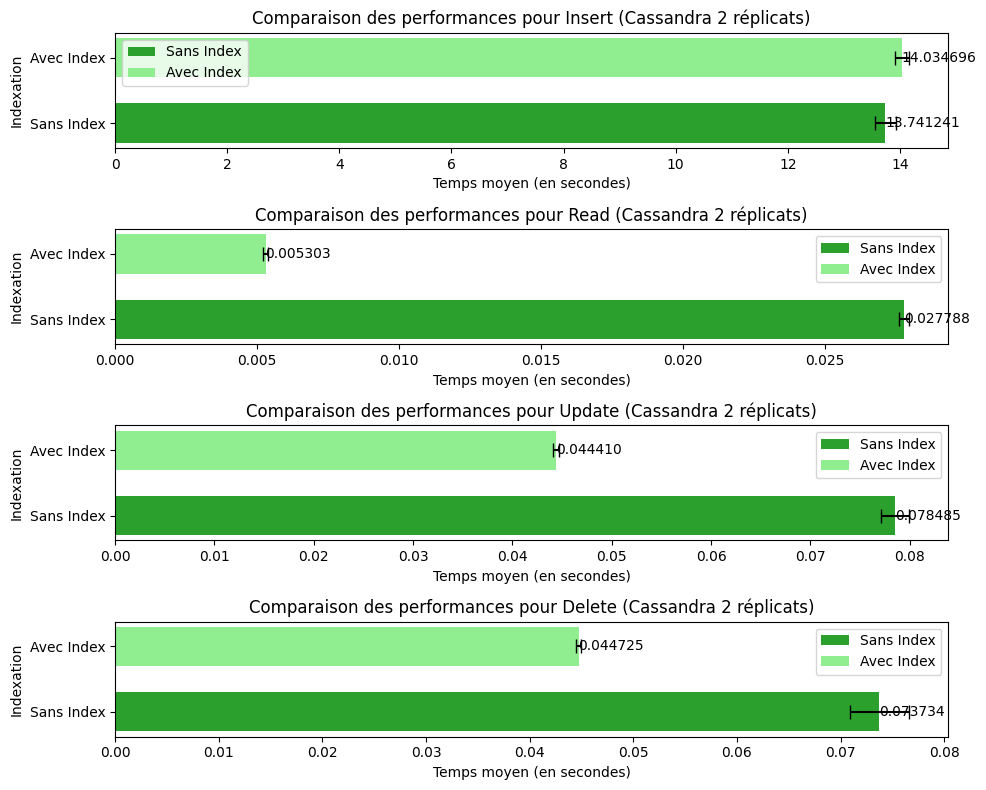

In [68]:
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_cassandra_massive_mean_time_2, read_cassandra_massive_mean_time_2, 
                      update_cassandra_massive_mean_time_2, delete_cassandra_massive_mean_time_2]
mean_with_index = [create_cassandra_massive_mean_time_2_index, read_cassandra_massive_mean_time_2_index, 
                   update_cassandra_massive_mean_time_2_index, delete_cassandra_massive_mean_time_2_index]

std_without_index = [create_cassandra_massive_std_time_2, read_cassandra_massive_std_time_2, 
                     update_cassandra_massive_std_time_2, delete_cassandra_massive_std_time_2]
std_with_index = [create_cassandra_massive_std_time_2_index, read_cassandra_massive_std_time_2_index, 
                  update_cassandra_massive_std_time_2_index, delete_cassandra_massive_std_time_2_index]

# Créer un graphique pour chaque action
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 4 graphiques sous le même format
width = 0.6

# Générer chaque sous-graphe pour chaque action
for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(2)  # 2 barres par graphique : Sans index, Avec index
    mean_values = [mean_without_index[i], mean_with_index[i]]
    std_values = [std_without_index[i], std_with_index[i]]

    # Dessiner les barres pour chaque action
    bars1 = ax.barh(x[0], mean_values[0], width, xerr=std_values[0], label='Sans Index', capsize=5, color='tab:green')
    bars2 = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Avec Index', capsize=5, color='#90EE90')

    # Titre et labels
    ax.set_xlabel('Temps moyen (en secondes)')
    ax.set_ylabel('Indexation')
    ax.set_title(f'Comparaison des performances pour {action} (Cassandra 2 réplicats)')
    ax.set_yticks(x)
    ax.set_yticklabels(['Sans Index', 'Avec Index'])
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()

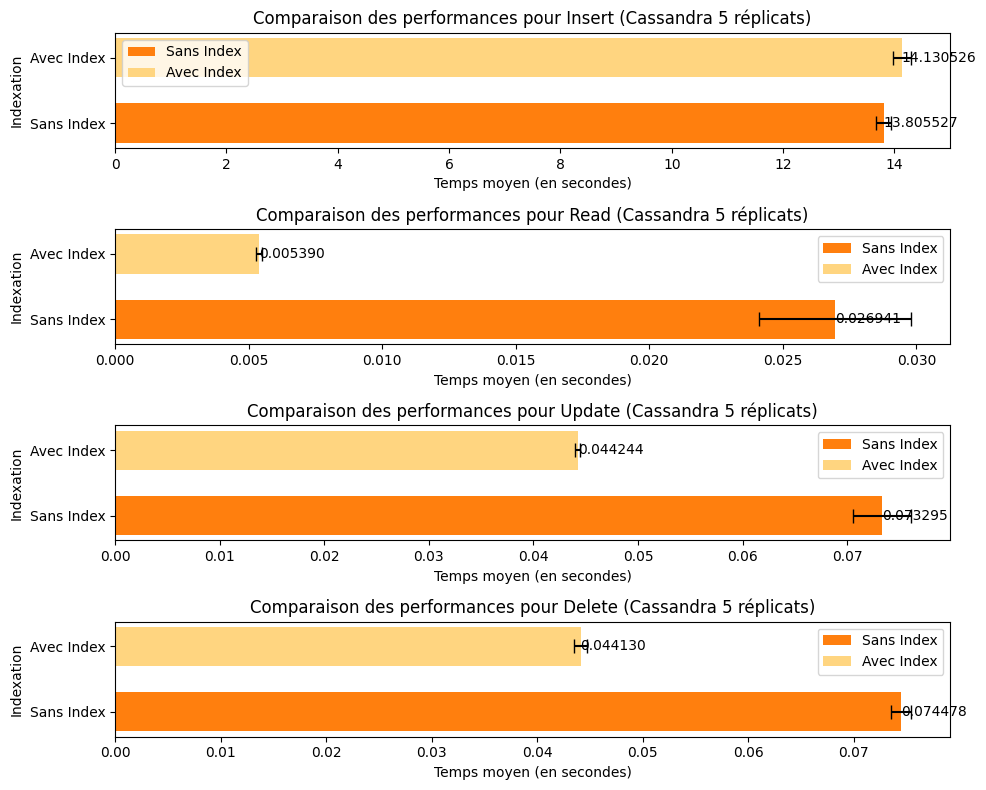

In [67]:
actions = ['Insert', 'Read', 'Update', 'Delete']

mean_without_index = [create_cassandra_massive_mean_time_5, read_cassandra_massive_mean_time_5, 
                      update_cassandra_massive_mean_time_5, delete_cassandra_massive_mean_time_5]
mean_with_index = [create_cassandra_massive_mean_time_5_index, read_cassandra_massive_mean_time_5_index, 
                   update_cassandra_massive_mean_time_5_index, delete_cassandra_massive_mean_time_5_index]


std_without_index = [create_cassandra_massive_std_time_5, read_cassandra_massive_std_time_5, 
                     update_cassandra_massive_std_time_5, delete_cassandra_massive_std_time_5]
std_with_index = [create_cassandra_massive_std_time_5_index, read_cassandra_massive_std_time_5_index, 
                  update_cassandra_massive_std_time_5_index, delete_cassandra_massive_std_time_5_index]

# Créer un graphique pour chaque action
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 4 graphiques sous le même format
width = 0.6

# Générer chaque sous-graphe pour chaque action
for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(2)  # 2 barres par graphique : Sans index, Avec index
    mean_values = [mean_without_index[i], mean_with_index[i]]
    std_values = [std_without_index[i], std_with_index[i]]

    # Dessiner les barres pour chaque action
    bars1 = ax.barh(x[0], mean_values[0], width, xerr=std_values[0], label='Sans Index', capsize=5, color='tab:orange')
    bars2 = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Avec Index', capsize=5, color='#FFD580')

    # Titre et labels
    ax.set_xlabel('Temps moyen (en secondes)')
    ax.set_ylabel('Indexation')
    ax.set_title(f'Comparaison des performances pour {action} (Cassandra 5 réplicats)')
    ax.set_yticks(x)
    ax.set_yticklabels(['Sans Index', 'Avec Index'])
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.6f}', va='center', ha='left')

    add_values(bars1)
    add_values(bars2)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()

##### Comparaison de la mémoire avec et sans les index

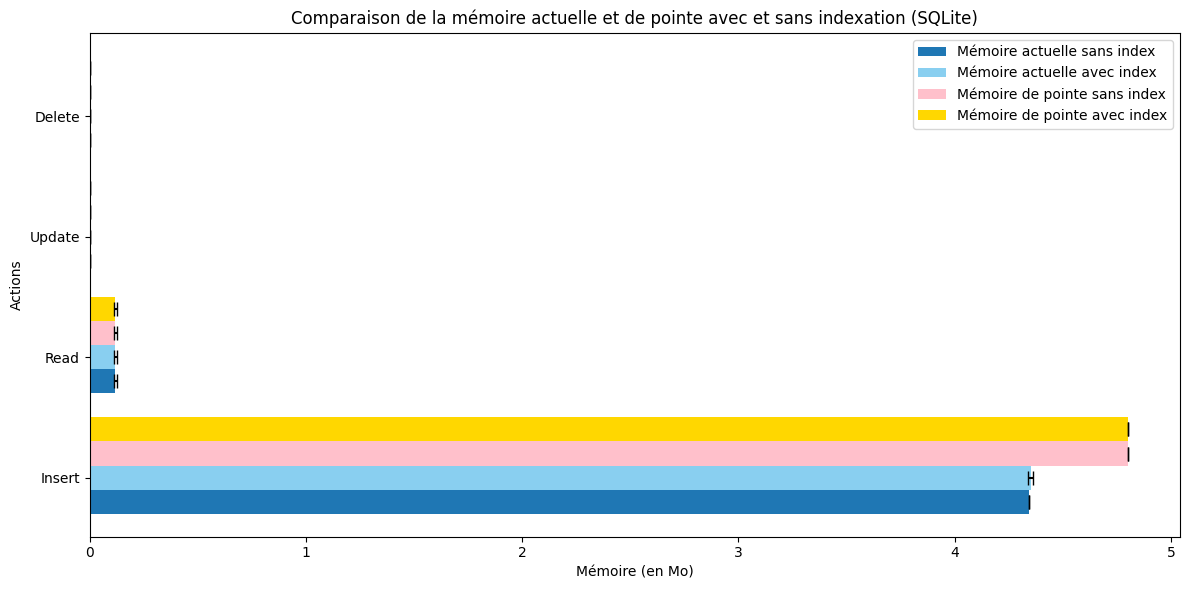

In [51]:
actions = ['Insert', 'Read', 'Update', 'Delete']

# Moyennes et écarts types pour la mémoire actuelle
mean_current_without_index = [create_sqlite_massive_mean_current_memory, read_sqlite_massive_mean_current_memory, 
                              update_sqlite_massive_mean_current_memory, delete_sqlite_massive_mean_current_memory]
mean_current_with_index = [create_sqlite_massive_mean_current_memory_index, read_sqlite_massive_mean_current_memory_index, 
                           update_sqlite_massive_mean_current_memory_index, delete_sqlite_massive_mean_current_memory_index]
std_current_without_index = [create_sqlite_massive_std_current_memory, read_sqlite_massive_std_current_memory, 
                             update_sqlite_massive_std_current_memory, delete_sqlite_massive_std_current_memory]
std_current_with_index = [create_sqlite_massive_std_current_memory_index, read_sqlite_massive_std_current_memory_index, 
                          update_sqlite_massive_std_current_memory_index, delete_sqlite_massive_std_current_memory_index]

# Moyennes et écarts types pour la mémoire de pointe
mean_peak_without_index = [create_sqlite_massive_mean_peak_memory, read_sqlite_massive_mean_peak_memory, 
                           update_sqlite_massive_mean_peak_memory, delete_sqlite_massive_mean_peak_memory]
mean_peak_with_index = [create_sqlite_massive_mean_peak_memory_index, read_sqlite_massive_mean_peak_memory_index, 
                        update_sqlite_massive_mean_peak_memory_index, delete_sqlite_massive_mean_peak_memory_index]
std_peak_without_index = [create_sqlite_massive_std_peak_memory, read_sqlite_massive_std_peak_memory, 
                          update_sqlite_massive_std_peak_memory, delete_sqlite_massive_std_peak_memory]
std_peak_with_index = [create_sqlite_massive_std_peak_memory_index, read_sqlite_massive_std_peak_memory_index, 
                       update_sqlite_massive_std_peak_memory_index, delete_sqlite_massive_std_peak_memory_index]

x = np.arange(len(actions))
width = 0.2  # Réduire la largeur pour accueillir plus de barres

fig, ax = plt.subplots(figsize=(12, 6))

# Barres pour la mémoire actuelle
bars_current_without = ax.barh(x - width, mean_current_without_index, height=width, xerr=std_current_without_index, 
                               label='Mémoire actuelle sans index', capsize=5, color='tab:blue')
bars_current_with = ax.barh(x, mean_current_with_index, height=width, xerr=std_current_with_index, 
                            label='Mémoire actuelle avec index', capsize=5, color='#89CFF0')

# Barres pour la mémoire de pointe
bars_peak_without = ax.barh(x + width, mean_peak_without_index, height=width, xerr=std_peak_without_index, 
                            label='Mémoire de pointe sans index', capsize=5, color='pink')
bars_peak_with = ax.barh(x + 2 * width, mean_peak_with_index, height=width, xerr=std_peak_with_index, 
                         label='Mémoire de pointe avec index', capsize=5, color='gold')

# Ajustements des axes et légende
ax.set_ylabel('Actions')
ax.set_xlabel('Mémoire (en Mo)')
ax.set_title('Comparaison de la mémoire actuelle et de pointe avec et sans indexation (SQLite)')
ax.set_yticks(x)
ax.set_yticklabels(actions)
ax.legend()

plt.tight_layout()
plt.show()


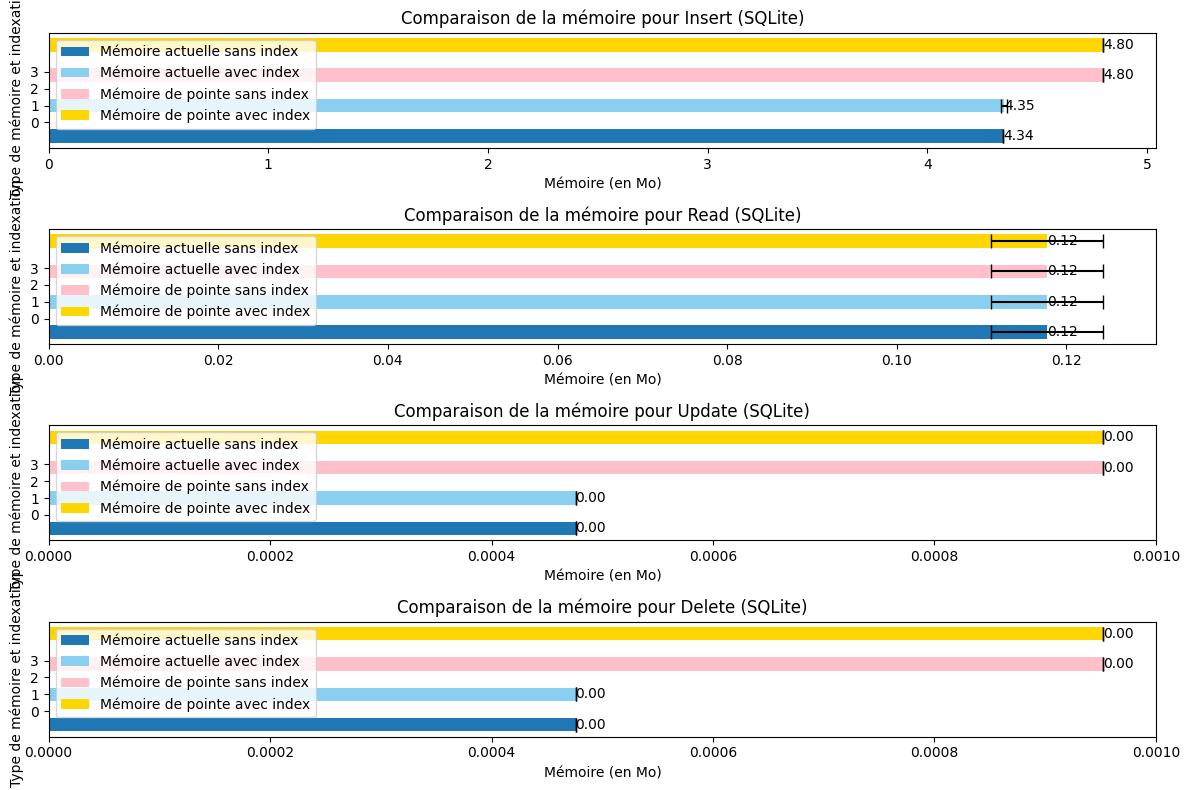

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

actions = ['Insert', 'Read', 'Update', 'Delete']

# Moyennes et écarts types pour la mémoire actuelle
mean_current_without_index = [create_sqlite_massive_mean_current_memory, read_sqlite_massive_mean_current_memory, 
                              update_sqlite_massive_mean_current_memory, delete_sqlite_massive_mean_current_memory]
mean_current_with_index = [create_sqlite_massive_mean_current_memory_index, read_sqlite_massive_mean_current_memory_index, 
                           update_sqlite_massive_mean_current_memory_index, delete_sqlite_massive_mean_current_memory_index]
std_current_without_index = [create_sqlite_massive_std_current_memory, read_sqlite_massive_std_current_memory, 
                             update_sqlite_massive_std_current_memory, delete_sqlite_massive_std_current_memory]
std_current_with_index = [create_sqlite_massive_std_current_memory_index, read_sqlite_massive_std_current_memory_index, 
                          update_sqlite_massive_std_current_memory_index, delete_sqlite_massive_std_current_memory_index]

# Moyennes et écarts types pour la mémoire de pointe
mean_peak_without_index = [create_sqlite_massive_mean_peak_memory, read_sqlite_massive_mean_peak_memory, 
                           update_sqlite_massive_mean_peak_memory, delete_sqlite_massive_mean_peak_memory]
mean_peak_with_index = [create_sqlite_massive_mean_peak_memory_index, read_sqlite_massive_mean_peak_memory_index, 
                        update_sqlite_massive_mean_peak_memory_index, delete_sqlite_massive_mean_peak_memory_index]
std_peak_without_index = [create_sqlite_massive_std_peak_memory, read_sqlite_massive_std_peak_memory, 
                          update_sqlite_massive_std_peak_memory, delete_sqlite_massive_std_peak_memory]
std_peak_with_index = [create_sqlite_massive_std_peak_memory_index, read_sqlite_massive_std_peak_memory_index, 
                       update_sqlite_massive_std_peak_memory_index, delete_sqlite_massive_std_peak_memory_index]

# Créer un graphique pour chaque action
fig, axes = plt.subplots(4, 1, figsize=(12, 8))  # 4 graphiques sous le même format
width = 0.8  # Réduire la largeur pour accueillir plus de barres

# Générer chaque sous-graphe pour chaque action
for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(4)  # 4 barres par graphique : Mem actuelle sans index, Mem actuelle avec index, Mem de pointe sans index, Mem de pointe avec index
    mean_values = [mean_current_without_index[i], mean_current_with_index[i], mean_peak_without_index[i], mean_peak_with_index[i]]
    std_values = [std_current_without_index[i], std_current_with_index[i], std_peak_without_index[i], std_peak_with_index[i]]

    # Dessiner les barres pour chaque action
    bars_current_without = ax.barh(x[0] - width, mean_values[0], width, xerr=std_values[0], label='Mémoire actuelle sans index', capsize=5, color='tab:blue')
    bars_current_with = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Mémoire actuelle avec index', capsize=5, color='#89CFF0')
    bars_peak_without = ax.barh(x[2] + width, mean_values[2], width, xerr=std_values[2], label='Mémoire de pointe sans index', capsize=5, color='pink')
    bars_peak_with = ax.barh(x[3] + 2 * width, mean_values[3], width, xerr=std_values[3], label='Mémoire de pointe avec index', capsize=5, color='gold')

    # Titre et labels
    ax.set_xlabel('Mémoire (en Mo)')
    ax.set_ylabel('Type de mémoire et indexation')
    ax.set_title(f'Comparaison de la mémoire pour {action} (SQLite)')
    ax.set_yticks(x)
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

    add_values(bars_current_without)
    add_values(bars_current_with)
    add_values(bars_peak_without)
    add_values(bars_peak_with)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()


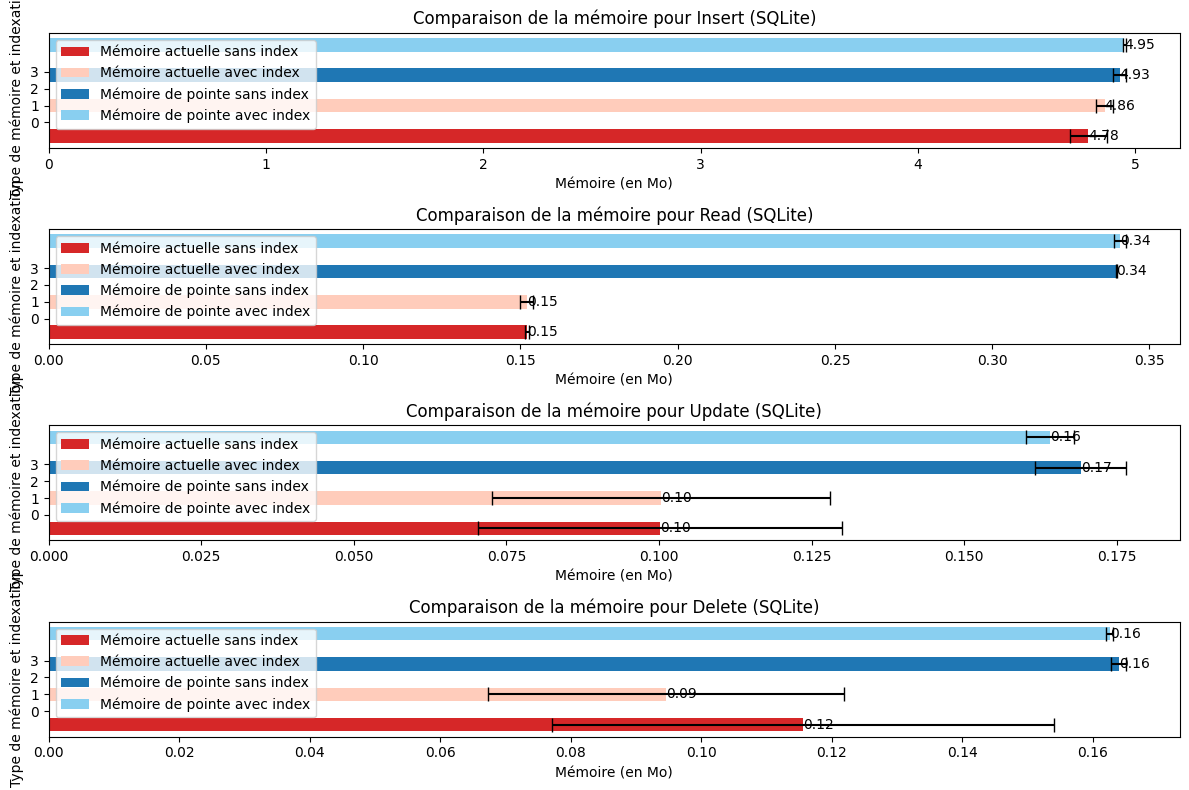

In [77]:
actions = ['Insert', 'Read', 'Update', 'Delete']

# Moyennes et écarts types pour la mémoire actuelle
mean_current_without_index = [create_cas_mean_current_memory, read_cas_mean_current_memory, 
                              update_cas_mean_current_memory, delete_cas_mean_current_memory]
mean_current_with_index = [create_cassandra_mean_current_memory_index, read_cassandra_mean_current_memory_index, 
                           update_cassandra_mean_current_memory_index, delete_cassandra_mean_current_memory_index]
std_current_without_index = [create_cas_std_current_memory, read_cas_std_current_memory, 
                             update_cas_std_current_memory, delete_cas_std_current_memory]
std_current_with_index = [create_cassandra_std_current_memory_index, read_cassandra_std_current_memory_index, 
                          update_cassandra_std_current_memory_index, delete_cassandra_std_current_memory_index]

# Moyennes et écarts types pour la mémoire de pointe
mean_peak_without_index = [create_cas_mean_peak_memory, read_cas_mean_peak_memory, 
                           update_cas_mean_peak_memory, delete_cas_mean_peak_memory]
mean_peak_with_index = [create_cassandra_mean_peak_memory_index, read_cassandra_mean_peak_memory_index, 
                        update_cassandra_mean_peak_memory_index, delete_cassandra_mean_peak_memory_index]
std_peak_without_index = [create_cas_std_peak_memory, read_cas_std_peak_memory, 
                          update_cas_std_peak_memory, delete_cas_std_peak_memory]
std_peak_with_index = [create_cassandra_std_peak_memory_index, read_cassandra_std_peak_memory_index, 
                       update_cassandra_std_peak_memory_index, delete_cassandra_std_peak_memory_index]

# Créer un graphique pour chaque action
fig, axes = plt.subplots(4, 1, figsize=(12, 8))  # 4 graphiques sous le même format
width = 0.8  # Réduire la largeur pour accueillir plus de barres

# Générer chaque sous-graphe pour chaque action
for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(4)  # 4 barres par graphique : Mem actuelle sans index, Mem actuelle avec index, Mem de pointe sans index, Mem de pointe avec index
    mean_values = [mean_current_without_index[i], mean_current_with_index[i], mean_peak_without_index[i], mean_peak_with_index[i]]
    std_values = [std_current_without_index[i], std_current_with_index[i], std_peak_without_index[i], std_peak_with_index[i]]

    # Dessiner les barres pour chaque action
    bars_current_without = ax.barh(x[0] - width, mean_values[0], width, xerr=std_values[0], label='Mémoire actuelle sans index', capsize=5, color='tab:red')
    bars_current_with = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Mémoire actuelle avec index', capsize=5, color='#FFCCBB')
    bars_peak_without = ax.barh(x[2] + width, mean_values[2], width, xerr=std_values[2], label='Mémoire de pointe sans index', capsize=5, color='tab:blue')
    bars_peak_with = ax.barh(x[3] + 2 * width, mean_values[3], width, xerr=std_values[3], label='Mémoire de pointe avec index', capsize=5, color='#89CFF0')

    # Titre et labels
    ax.set_xlabel('Mémoire (en Mo)')
    ax.set_ylabel('Type de mémoire et indexation')
    ax.set_title(f'Comparaison de la mémoire pour {action} (Cassandra 1 réplicat)')
    ax.set_yticks(x)
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

    add_values(bars_current_without)
    add_values(bars_current_with)
    add_values(bars_peak_without)
    add_values(bars_peak_with)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()


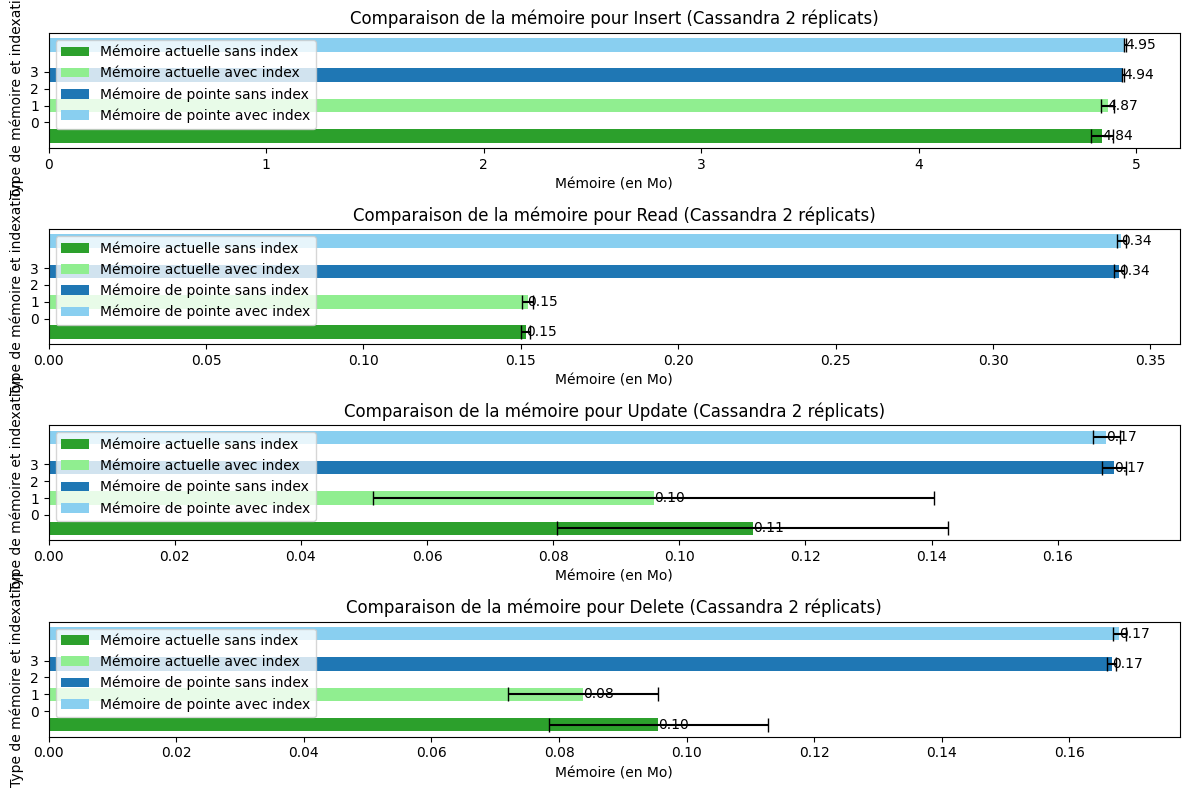

In [80]:
actions = ['Insert', 'Read', 'Update', 'Delete']

# Moyennes et écarts types pour la mémoire actuelle
mean_current_without_index = [create_cassandra_massive_mean_current_memory_2, read_cassandra_massive_mean_current_memory_2, 
                              update_cassandra_massive_mean_current_memory_2, delete_cassandra_massive_mean_current_memory_2]
mean_current_with_index = [create_cassandra_massive_mean_current_memory_2_index, read_cassandra_massive_mean_current_memory_2_index, 
                           update_cassandra_massive_mean_current_memory_2_index, delete_cassandra_massive_mean_current_memory_2_index]
std_current_without_index = [create_cassandra_massive_std_current_memory_2, read_cassandra_massive_std_current_memory_2, 
                             update_cassandra_massive_std_current_memory_2, delete_cassandra_massive_std_current_memory_2]
std_current_with_index = [create_cassandra_massive_std_current_memory_2_index, read_cassandra_massive_std_current_memory_2_index, 
                          update_cassandra_massive_std_current_memory_2_index, delete_cassandra_massive_std_current_memory_2_index]

# Moyennes et écarts types pour la mémoire de pointe
mean_peak_without_index = [create_cassandra_massive_mean_peak_memory_2, read_cassandra_massive_mean_peak_memory_2, 
                           update_cassandra_massive_mean_peak_memory_2, delete_cassandra_massive_mean_peak_memory_2]
mean_peak_with_index =  [create_cassandra_massive_mean_peak_memory_2_index, read_cassandra_massive_mean_peak_memory_2_index, 
                           update_cassandra_massive_mean_peak_memory_2_index, delete_cassandra_massive_mean_peak_memory_2_index]
std_peak_without_index = [create_cassandra_massive_std_peak_memory_2, read_cassandra_massive_std_peak_memory_2, 
                          update_cassandra_massive_std_peak_memory_2, delete_cassandra_massive_std_peak_memory_2]
std_peak_with_index = [create_cassandra_massive_std_peak_memory_2_index, read_cassandra_massive_std_peak_memory_2_index, 
                          update_cassandra_massive_std_peak_memory_2_index, delete_cassandra_massive_std_peak_memory_2_index]

# Créer un graphique pour chaque action
fig, axes = plt.subplots(4, 1, figsize=(12, 8))  # 4 graphiques sous le même format
width = 0.8  # Réduire la largeur pour accueillir plus de barres

# Générer chaque sous-graphe pour chaque action
for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(4)  # 4 barres par graphique : Mem actuelle sans index, Mem actuelle avec index, Mem de pointe sans index, Mem de pointe avec index
    mean_values = [mean_current_without_index[i], mean_current_with_index[i], mean_peak_without_index[i], mean_peak_with_index[i]]
    std_values = [std_current_without_index[i], std_current_with_index[i], std_peak_without_index[i], std_peak_with_index[i]]

    # Dessiner les barres pour chaque action
    bars_current_without = ax.barh(x[0] - width, mean_values[0], width, xerr=std_values[0], label='Mémoire actuelle sans index', capsize=5, color='tab:green')
    bars_current_with = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Mémoire actuelle avec index', capsize=5, color='#90EE90')
    bars_peak_without = ax.barh(x[2] + width, mean_values[2], width, xerr=std_values[2], label='Mémoire de pointe sans index', capsize=5, color='tab:blue')
    bars_peak_with = ax.barh(x[3] + 2 * width, mean_values[3], width, xerr=std_values[3], label='Mémoire de pointe avec index', capsize=5, color='#89CFF0')

    # Titre et labels
    ax.set_xlabel('Mémoire (en Mo)')
    ax.set_ylabel('Type de mémoire et indexation')
    ax.set_title(f'Comparaison de la mémoire pour {action} (Cassandra 2 réplicats)')
    ax.set_yticks(x)
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

    add_values(bars_current_without)
    add_values(bars_current_with)
    add_values(bars_peak_without)
    add_values(bars_peak_with)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()


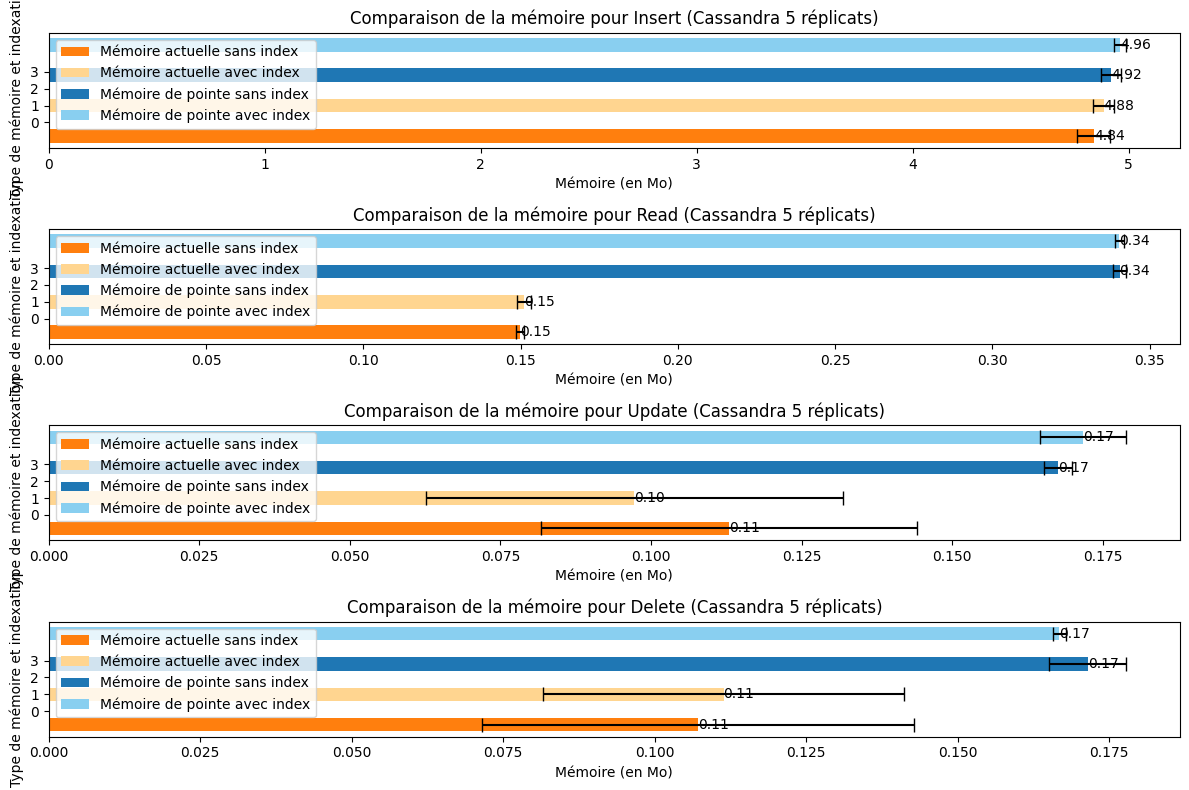

In [81]:
actions = ['Insert', 'Read', 'Update', 'Delete']

# Moyennes et écarts types pour la mémoire actuelle
mean_current_without_index = [create_cassandra_massive_mean_current_memory_5, read_cassandra_massive_mean_current_memory_5, 
                              update_cassandra_massive_mean_current_memory_5, delete_cassandra_massive_mean_current_memory_5]
mean_current_with_index = [create_cassandra_massive_mean_current_memory_5_index, read_cassandra_massive_mean_current_memory_5_index, 
                           update_cassandra_massive_mean_current_memory_5_index, delete_cassandra_massive_mean_current_memory_5_index]
std_current_without_index = [create_cassandra_massive_std_current_memory_5, read_cassandra_massive_std_current_memory_5, 
                             update_cassandra_massive_std_current_memory_5, delete_cassandra_massive_std_current_memory_5]
std_current_with_index = [create_cassandra_massive_std_current_memory_5_index, read_cassandra_massive_std_current_memory_5_index, 
                          update_cassandra_massive_std_current_memory_5_index, delete_cassandra_massive_std_current_memory_5_index]

# Moyennes et écarts types pour la mémoire de pointe
mean_peak_without_index = [create_cassandra_massive_mean_peak_memory_5, read_cassandra_massive_mean_peak_memory_5, 
                           update_cassandra_massive_mean_peak_memory_5, delete_cassandra_massive_mean_peak_memory_5]
mean_peak_with_index =  [create_cassandra_massive_mean_peak_memory_5_index, read_cassandra_massive_mean_peak_memory_5_index, 
                           update_cassandra_massive_mean_peak_memory_5_index, delete_cassandra_massive_mean_peak_memory_5_index]
std_peak_without_index = [create_cassandra_massive_std_peak_memory_5, read_cassandra_massive_std_peak_memory_5, 
                          update_cassandra_massive_std_peak_memory_5, delete_cassandra_massive_std_peak_memory_5]
std_peak_with_index = [create_cassandra_massive_std_peak_memory_5_index, read_cassandra_massive_std_peak_memory_5_index, 
                          update_cassandra_massive_std_peak_memory_5_index, delete_cassandra_massive_std_peak_memory_5_index]

# Créer un graphique pour chaque action
fig, axes = plt.subplots(4, 1, figsize=(12, 8))  # 4 graphiques sous le même format
width = 0.8  # Réduire la largeur pour accueillir plus de barres

# Générer chaque sous-graphe pour chaque action
for i, action in enumerate(actions):
    ax = axes[i]
    x = np.arange(4)  # 4 barres par graphique : Mem actuelle sans index, Mem actuelle avec index, Mem de pointe sans index, Mem de pointe avec index
    mean_values = [mean_current_without_index[i], mean_current_with_index[i], mean_peak_without_index[i], mean_peak_with_index[i]]
    std_values = [std_current_without_index[i], std_current_with_index[i], std_peak_without_index[i], std_peak_with_index[i]]

    # Dessiner les barres pour chaque action
    bars_current_without = ax.barh(x[0] - width, mean_values[0], width, xerr=std_values[0], label='Mémoire actuelle sans index', capsize=5, color='tab:orange')
    bars_current_with = ax.barh(x[1], mean_values[1], width, xerr=std_values[1], label='Mémoire actuelle avec index', capsize=5, color='#FFD590')
    bars_peak_without = ax.barh(x[2] + width, mean_values[2], width, xerr=std_values[2], label='Mémoire de pointe sans index', capsize=5, color='tab:blue')
    bars_peak_with = ax.barh(x[3] + 2 * width, mean_values[3], width, xerr=std_values[3], label='Mémoire de pointe avec index', capsize=5, color='#89CFF0')

    # Titre et labels
    ax.set_xlabel('Mémoire (en Mo)')
    ax.set_ylabel('Type de mémoire et indexation')
    ax.set_title(f'Comparaison de la mémoire pour {action} (Cassandra 5 réplicats)')
    ax.set_yticks(x)
    ax.legend()

    # Ajouter les valeurs aux barres
    def add_values(bars):
        for bar in bars:
            xval = bar.get_width()
            ax.text(xval, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', va='center', ha='left')

    add_values(bars_current_without)
    add_values(bars_current_with)
    add_values(bars_peak_without)
    add_values(bars_peak_with)

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()


TODO ZOE commenter

In [55]:
# TODO Charlotte tu veux dire quoi ?
# Tester avec des requêtes plus complexes
# Utiliser un dataset plus grand (ça c'est au dessus)
#  Ajouter des colonnes à indexer (c'est fait aussi au dessus)
# Tous ces TODO n'ont rien changé.

TOZO ZOE rédaction fin 

# Fin du notebook

In [82]:
# fermer proprement
session.shutdown() # Fermer la connexion Cassandra
cluster.shutdown() # Fermer le cluster Cassandra
conn.close() # Fermer la connexion SQLite